In [1]:
### start from here
from scipy.interpolate import CubicSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon
import numpy as np

import matplotlib.pyplot as plt
treated = ["ABINGTON",  "AMBLER",  "CHELTENHAM",  "COLLEGEVILLE",  "CONSHOHOCKEN", 
                   "EAST GREENVILLE",  "EAST NORRITON",  "FRANCONIA" , "GREEN LANE", "HATFIELD TOWNSHIP", 
                   "HORSHAM" , "JENKINTOWN",  "LANSDALE",  "LIMERICK",  "LOWER GWYNEDD", 
                   "LOWER MERION",  "LOWER MORELAND",  "LOWER POTTSGROVE",  "LOWER PROVIDENCE",  "LOWER SALFORD", 
                   "MARLBOROUGH",  "MONTGOMERY",  "NARBERTH",  "PENNSBURG",  "PERKIOMEN", 
                   "PLYMOUTH",  "POTTSTOWN",  "RED HILL",  "ROCKLEDGE",  "ROYERSFORD", 
                   "SCHWENKSVILLE",  "SKIPPACK",  "SOUDERTON",  "TELFORD",  "TOWAMENCIN", 
                   "UPPER DUBLIN",  "UPPER FREDERICK",  "UPPER GWYNEDD",  "UPPER HANOVER",  "UPPER MERION", 
                   "UPPER MORELAND",  "UPPER POTTSGROVE",  "UPPER PROVIDENCE",  "UPPER SALFORD",  "WEST CONSHOHOCKEN", 
                   "WEST NORRITON",  "WEST POTTSGROVE",  "WHITEMARSH",  "WHITPAIN",  "WORCESTER"]
control = ["BRIDGEPORT", "BRYN ATHYN", "DOUGLASS", "HATBORO", "HATFIELD BORO", 
                   "LOWER FREDERICK", "NEW HANOVER", "NORRISTOWN", "NORTH WALES", "SALFORD", 
                   "SPRINGFIELD", "TRAPPE"]         

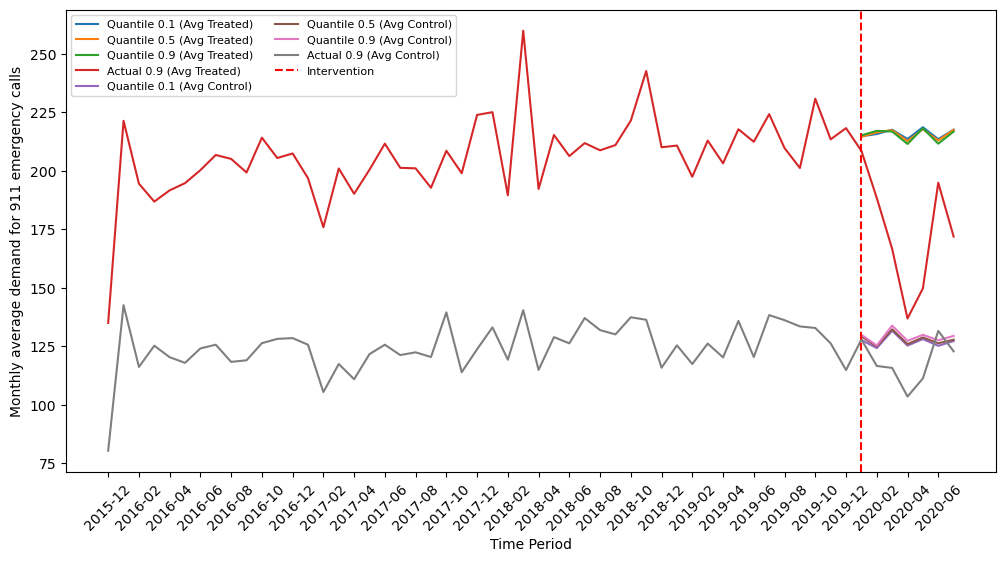

In [5]:

# Get a list of all CSV files in the folder for quantiles 0.1, 0.5, and 0.9
quantiles = ['0.1', '0.5', '0.9']
csv_files = {q: './results/nn_model_results/rnn/processed_ensemble_forecasts/callsMT2_LSTMcell_cocob_without_stl_decomposition_'+f'{q}.txt' for q in quantiles}


dataset_name = 'calls911_benchmarks'
data_index = pd.read_csv('./datasets/text_data/calls911/'+dataset_name+'.csv')
data_index.set_index(pd.to_datetime(data_index['date'], format = '%Y-%m-%d').apply(lambda x: x.strftime("%Y-%m")), inplace=True)
data_index = data_index.iloc[:,1:]

all_columns = data_index.columns.tolist()

# Create a binary mask indicating whether each column is treated (1) or control (0)
tnc = [1 if col in treated else 0 for col in all_columns]

# Create a dictionary to store the dataframes for each quantile
dfs = {q: [] for q in quantiles}

# Iterate over each quantile
for quantile, files in csv_files.items():
    # Iterate over each file for the quantile
    # Load the text data from CSV
    data = pd.read_csv(files, header=None)

    # Transpose the data for better visualization (units as rows, time periods as columns)
    transposed_data = data.transpose()

    # Append the transposed dataframe to the list for the current quantile
    dfs[quantile].append(transposed_data)

# Concatenate the dataframes along the columns (units) for each quantile
concatenated_data = {q: pd.concat(frames, axis=1) for q, frames in dfs.items()}


# a boolean list to denote whether the unit is treated or controled
tnc_bool = [bool(value) for value in tnc]
flipped_tnc_bool = [not value for value in tnc_bool]

# average predicted treated units
averages_predicted_treated = {q: concatenated_data[q][concatenated_data[q].columns[tnc_bool]].mean(axis=1) for q in quantiles}

# average actual treated units
averages_actual_treated = data_index[data_index.columns[tnc_bool]].mean(axis=1)

# average predicted control units
averages_predicted_control = {q: concatenated_data[q][concatenated_data[q].columns[flipped_tnc_bool]].mean(axis=1) for q in quantiles}

# average actual control units
averages_actual_control = data_index[data_index.columns[flipped_tnc_bool]].mean(axis=1)


# Plot the averages
fig, ax = plt.subplots(figsize=(12, 6))

for quantile, average_data in averages_predicted_treated.items():
    ax.plot((len(averages_actual_treated)-average_data.index-1)[::], average_data, label=f'Quantile {quantile} (Avg Treated)')
ax.plot(averages_actual_treated.index, averages_actual_treated, label=f'Actual {quantile} (Avg Treated)')

for quantile, average_data in averages_predicted_control.items():
    ax.plot((len(averages_actual_treated)-average_data.index-1)[::-1], average_data, label=f'Quantile {quantile} (Avg Control)')
ax.plot(averages_actual_control.index, averages_actual_control, label=f'Actual {quantile} (Avg Control)')

# Add a vertical line at 2020-01
plt.axvline("2020-01", color='red', linestyle='--', label='Intervention')

ax.set_xlabel('Time Period')
ax.set_ylabel('Monthly average demand for 911 emergency calls')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=8)
plt.xticks(averages_actual_control.index[::2],rotation=45)
plt.show()

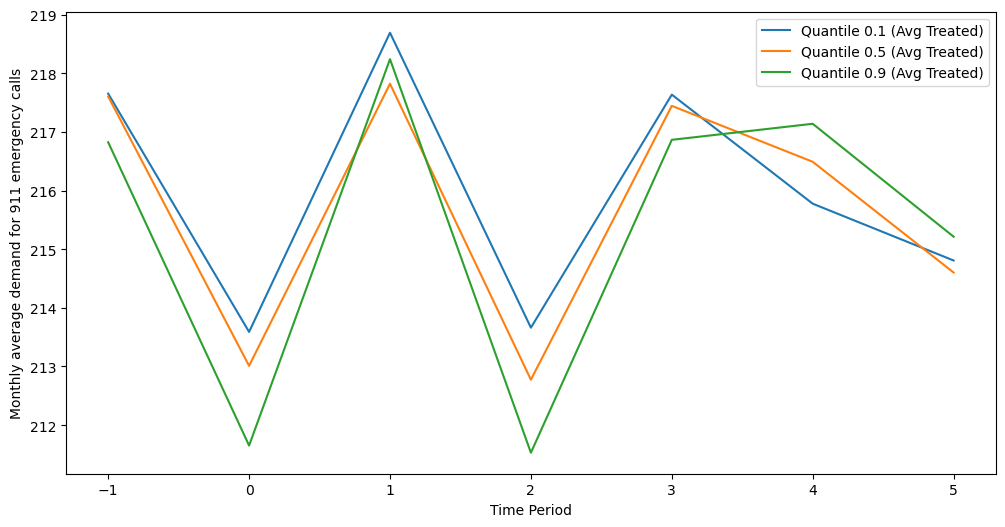

In [6]:
# Plot the averages
fig, ax = plt.subplots(figsize=(12, 6))

for quantile, average_data in averages_predicted_treated.items():
    ax.plot(average_data.index-1, average_data, label=f'Quantile {quantile} (Avg Treated)')

# for quantile, average_data in averages_predicted_control.items():
#     ax.plot((len(averages_actual_treated)-average_data.index-1)[::-1], average_data, label=f'Quantile {quantile} (Avg Control)')

ax.set_xlabel('Time Period')
ax.set_ylabel('Monthly average demand for 911 emergency calls')
ax.legend()
# ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=9)
# plt.xticks(averages_actual_control.index[::2],rotation=45)
plt.show()

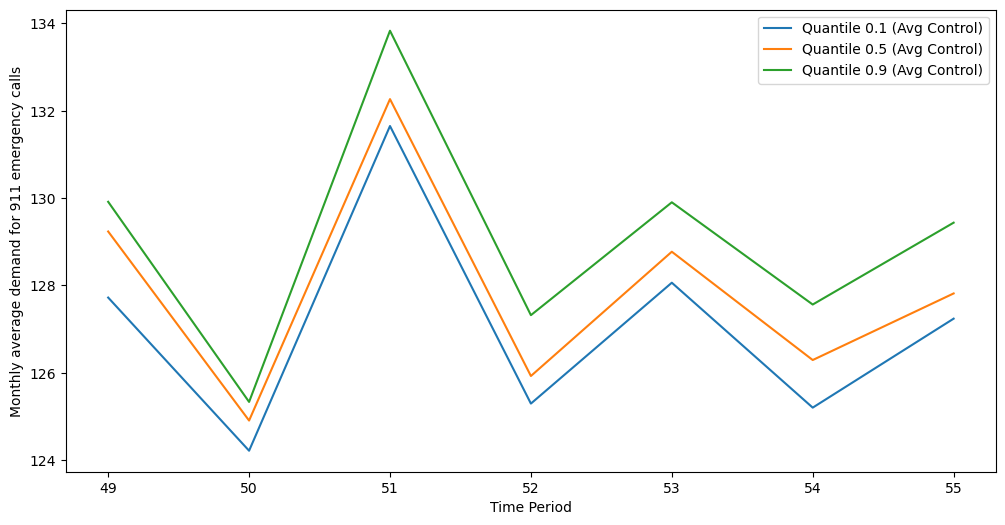

In [7]:
# Plot the averages
fig, ax = plt.subplots(figsize=(12, 6))

# for quantile, average_data in averages_predicted_treated.items():
#     ax.plot(average_data.index-1, average_data, label=f'Quantile {quantile} (Avg Treated)')

for quantile, average_data in averages_predicted_control.items():
    ax.plot((len(averages_actual_treated)-average_data.index-1)[::-1], average_data, label=f'Quantile {quantile} (Avg Control)')

ax.set_xlabel('Time Period')
ax.set_ylabel('Monthly average demand for 911 emergency calls')
ax.legend()
# ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=9)
# plt.xticks(averages_actual_control.index[::2],rotation=45)
plt.show()

In [10]:
# MEAN DIFFERENCE TESTING

# 1. Preparing the data
for q in quantiles:
    # Treated group
    diff_I = pd.DataFrame(averages_predicted_treated[q], columns=['Predicted'])
    diff_I['Y'] = list(averages_actual_treated[-len(averages_predicted_treated[q]):].values)
    diff_I['ab_diff'] = abs(diff_I['Predicted'] - diff_I['Y'])
    diff_I['ab_sum_av'] = (abs(diff_I['Predicted']) + abs(diff_I['Y'])) / 2
    diff_I['ab_diff_propY'] = diff_I['ab_diff'] / diff_I['Y']
    diff_I['ab_diff_propT'] = diff_I['ab_diff'] / diff_I['Predicted']
    diff_I['ab_diff_propYF'] = diff_I['ab_diff'] / diff_I['ab_sum_av']


    # Control group
    diff_NI = pd.DataFrame(averages_predicted_control[q], columns=['Predicted'])
    diff_NI['Y'] = list(averages_actual_control[-len(averages_predicted_control[q]):].values)
    diff_NI['ab_diff'] = abs(diff_NI['Predicted'] - diff_NI['Y'])
    diff_NI['ab_sum_av'] = (abs(diff_NI['Predicted']) + abs(diff_NI['Y'])) / 2
    diff_NI['ab_diff_propY'] = diff_NI['ab_diff'] / diff_NI['Y']
    diff_NI['ab_diff_propT'] = diff_NI['ab_diff'] / diff_NI['Predicted']
    diff_NI['ab_diff_propYF'] = diff_NI['ab_diff'] / diff_NI['ab_sum_av']

    # 2. MEAN SIGNIFICANCE TESTS FOR relative differences
    diff_I_vec = diff_I['ab_diff_propT'].values * 100
    diff_NI_vec = diff_NI['ab_diff_propT'].values * 100
    print(q)
    # Display mean and median for each group
    print("Treated Group TTE - Mean:", diff_I['ab_diff'].mean())
    print("Control Group TTE - Mean:", diff_NI['ab_diff'].mean())

    print("Treated Group - Mean:", diff_I_vec.mean(), "Median:", pd.Series(diff_I_vec).median())
    print("Control Group - Mean:", diff_NI_vec.mean(), "Median:", pd.Series(diff_NI_vec).median())
    if q == "0.5":
        # Shapiro-Wilk’s test for normality
        shapiro_diff_I = shapiro(diff_I_vec)
        shapiro_diff_NI = shapiro(diff_NI_vec)

        print("Shapiro-Wilk test p-value for Treated Group:", shapiro_diff_I.pvalue)
        print("Shapiro-Wilk test p-value for Control Group:", shapiro_diff_NI.pvalue)

        # Apply t-test if data is normally distributed, otherwise Wilcoxon signed-rank test
        if shapiro_diff_I.pvalue > 0.05 and shapiro_diff_NI.pvalue > 0.05:
            t_test_result = ttest_rel(diff_I_vec, diff_NI_vec)
            print("T-Test p-value:", t_test_result.pvalue)
        else:
            wilcoxon_test_result = wilcoxon(diff_I_vec, diff_NI_vec)
            print("Wilcoxon test p-value:", wilcoxon_test_result.pvalue)

0.1
Treated Group TTE - Mean: 42.08429884462212
Control Group TTE - Mean: 10.446486880293282
Treated Group - Mean: 19.494423139795067 Median: 19.965307920184205
Control Group - Mean: 8.208475537454818 Median: 6.14614858571603
0.5
Treated Group TTE - Mean: 41.78916027919133
Control Group TTE - Mean: 10.912430991402596
Treated Group - Mean: 19.398517897300415 Median: 19.888804920739663
Control Group - Mean: 8.525667853556655 Median: 6.665019663781571
Shapiro-Wilk test p-value for Treated Group: 0.8075667023658752
Shapiro-Wilk test p-value for Control Group: 0.5748091340065002
T-Test p-value: 0.003952851840901288
0.9
Treated Group TTE - Mean: 41.46267802710146
Control Group TTE - Mean: 11.704676378578089
Treated Group - Mean: 19.279602024935315 Median: 20.11611389375507
Control Group - Mean: 9.050808238337556 Median: 6.982702054321376


In [124]:


# Get a list of all CSV files in the folder for quantiles 0.1, 0.5, and 0.9
quantiles = ['0.1', '0.5', '0.9']
dataset_name = 'sim_10_60_l_he'


series_id      value      c_t  time_series_length  \
time                                                                          
1      10_1_60_linear_heterogeneous   4.000000  control                  60   
1      10_2_60_linear_heterogeneous   4.000000  control                  60   
1      10_3_60_linear_heterogeneous   4.000000  control                  60   
1      10_4_60_linear_heterogeneous   4.000000  control                  60   
1      10_5_60_linear_heterogeneous   4.000000  control                  60   
...                             ...        ...      ...                 ...   
60     10_6_60_linear_heterogeneous   5.331190  treated                  60   
60     10_7_60_linear_heterogeneous   3.879921  treated                  60   
60     10_8_60_linear_heterogeneous  12.673118  treated                  60   
60     10_9_60_linear_heterogeneous   8.400910  treated                  60   
60    10_10_60_linear_heterogeneous   5.751389  treated                  60   

      amount_of_time_series     dgp te_intervention tnc  
time                                                     
1                        10  linear   heterogeneous   0  
1                        10  linear   heterogeneous   0  
1                        10  linear   heterogeneous   0  
1                        10  linear   heterogeneous   0  
1                        10  linear   heterogeneous   0  
...                     ...     ...             ...  ..  
60                       10  linear   heterogeneous   1  
60                       10  linear   heterogeneous   1  
60                       10  linear   heterogeneous   1  
60                       10  linear   heterogeneous   1  
60                       10  linear   heterogeneous   1  

[600 rows x 8 columns]

In [43]:
# Sample DataFrame (replace this with your actual data)
data = {
    'Time_Period_1': [1, 2, 3, 4, 5],
    'Time_Period_2': [5, 4, 3, 2, 1],
    'Time_Period_3': [2, 3, 1, 4, 5],
}

df = pd.DataFrame(data)
print(df)
# Calculate the quantiles for each unit at each time period
quantiles_df = df.apply(lambda col: col.quantile([0.25, 0.5, 0.75])).transpose()

# Display the resulting DataFrame with quantiles
print(quantiles_df)

   Time_Period_1  Time_Period_2  Time_Period_3
0              1              5              2
1              2              4              3
2              3              3              1
3              4              2              4
4              5              1              5
               0.25  0.50  0.75
Time_Period_1   2.0   3.0   4.0
Time_Period_2   2.0   3.0   4.0
Time_Period_3   2.0   3.0   4.0


In [9]:
int(101/2)

50

In [27]:


def table2(dataset_name, data_type, model, forecast_horizon, plot_or_not=False):

    quantiles = ['0.1', '0.5', '0.9']
    concatenated_data = None
    single_data = None
    csv_files = None
    if data_type == 'calls911' and model == 'DeepProbCP':
        csv_files = {q: './results/nn_model_results/rnn/processed_ensemble_forecasts/callsMT2_LSTMcell_cocob_without_stl_decomposition_'\
                 +f'{q}.txt' for q in quantiles}  
    elif data_type == 'sim' and model == 'DeepProbCP':
        csv_files = {q: './results/nn_model_results/rnn/processed_ensemble_forecasts/'+dataset_name+'_LSTMcell_cocob_without_stl_decomposition_'\
                 +f'{q}.txt' for q in quantiles}  
    # elif model in ['DeepProbCP', 'deepAR']:
    #     # Get a list of all CSV files in the folder for quantiles 0.1, 0.5, and 0.9
    #     csv_files = {q: './results/benchmarks/predicted/' + dataset_name +\
    #              '_' + model +f'_{q}.txt' for q in quantiles}
    elif model == 'tft':
        csv_files = {q: './results/benchmarks/predicted/' + dataset_name +\
                 '_' + model +f'_{q}.csv' for q in quantiles}
    elif model in ['causalimpact', 'tsmixer']:
        single_data = pd.read_csv('./results/benchmarks/predicted/' + dataset_name +\
                 '_' + model +'.csv', header=None).T
        
    if csv_files:
        # Create a dictionary to store the dataframes for each quantile
        dfs = {q: [] for q in quantiles}

        # Iterate over each quantile
        for quantile, files in csv_files.items():
            # Iterate over each file for the quantile
            # Load the text data from CSV
            data = pd.read_csv(files, header=None)

            # Transpose the data for better visualization (units as rows, time periods as columns)
            transposed_data = data.transpose()

            # Append the transposed dataframe to the list for the current quantile
            dfs[quantile].append(transposed_data)

        # Concatenate the dataframes along the columns (units) for each quantile
        concatenated_data = {q: pd.concat(frames, axis=1) for q, frames in dfs.items()}
        print(concatenated_data['0.5'].shape)
    
    data_wor = pd.read_csv('./datasets/text_data/'+data_type+'/'+dataset_name+'.csv')
    data_wr = pd.read_csv('./datasets/text_data/'+data_type+'/'+dataset_name+'_for_errors.csv').iloc[:,1:]
    no_of_series = len(data_wor.columns)
    length_of_series = len(data_wor.index)
    if data_type == "calls911":
        treated = ["ABINGTON",  "AMBLER",  "CHELTENHAM",  "COLLEGEVILLE",  "CONSHOHOCKEN",
                  "EAST GREENVILLE",  "EAST NORRITON",  "FRANCONIA" , "GREEN LANE", "HATFIELD TOWNSHIP",
                  "HORSHAM" , "JENKINTOWN",  "LANSDALE",  "LIMERICK",  "LOWER GWYNEDD",
                  "LOWER MERION",  "LOWER MORELAND",  "LOWER POTTSGROVE",  "LOWER PROVIDENCE",  "LOWER SALFORD",
                  "MARLBOROUGH",  "MONTGOMERY",  "NARBERTH",  "PENNSBURG",  "PERKIOMEN",
                  "PLYMOUTH",  "POTTSTOWN",  "RED HILL",  "ROCKLEDGE",  "ROYERSFORD",
                  "SCHWENKSVILLE",  "SKIPPACK",  "SOUDERTON",  "TELFORD",  "TOWAMENCIN",
                  "UPPER DUBLIN",  "UPPER FREDERICK",  "UPPER GWYNEDD",  "UPPER HANOVER",  "UPPER MERION",
                  "UPPER MORELAND",  "UPPER POTTSGROVE",  "UPPER PROVIDENCE",  "UPPER SALFORD",  "WEST CONSHOHOCKEN",
                  "WEST NORRITON",  "WEST POTTSGROVE",  "WHITEMARSH",  "WHITPAIN",  "WORCESTER"]
        control = ["BRIDGEPORT", "BRYN ATHYN", "DOUGLASS", "HATBORO", "HATFIELD BORO",
                      "LOWER FREDERICK", "NEW HANOVER", "NORRISTOWN", "NORTH WALES", "SALFORD",
                      "SPRINGFIELD", "TRAPPE"]
        
        data_wor.set_index(pd.to_datetime(data_wor['date'], format = '%Y-%m-%d').apply(lambda x: x.strftime("%Y-%m")), inplace=True)
        all_columns = data_wor.columns[1:].tolist()
        # Create a binary mask indicating whether each column is treated (1) or control (0)
        tnc = [1 if col in treated else 0 for col in all_columns]
        data_index = data_wor.iloc[:,1:]
    if data_type == "sim":
        tnc = [0] * int((no_of_series)/2) +\
            [1] * int(no_of_series-int((no_of_series)/2))
        print(len(tnc))
        actual_treated_orig_A = data_wr.iloc[length_of_series-forecast_horizon:, int(no_of_series-int((no_of_series)/2))-1:]
        data_index = data_wor
    # a boolean list to denote whether the unit is treated or controled
    tnc_bool = [bool(value) for value in tnc]
    flipped_tnc_bool = [not value for value in tnc_bool]

    
    if concatenated_data:
        # print(concatenated_data['0.1'])
        # average predicted treated units
        averages_predicted_treated = {q: concatenated_data[q][concatenated_data[q].columns[tnc_bool]].mean(axis=1) for q in quantiles}
        # print(data_index)
        # average actual treated units
        actual_treated_intervened = data_index[data_index.columns[tnc_bool]]
        averages_actual_treated = actual_treated_intervened.mean(axis=1)

        # average predicted control units
        averages_predicted_control = {q: concatenated_data[q][concatenated_data[q].columns[flipped_tnc_bool]].mean(axis=1) for q in quantiles}

        # average actual control units
        averages_actual_control = data_index[data_index.columns[flipped_tnc_bool]].mean(axis=1)

        # for tte
        if model == 'DeepProbCP':
            # quantile_90_pred = concatenated_data['0.9'][concatenated_data['0.9'].columns[tnc_bool]]
            cs = CubicSpline(list(concatenated_data.keys()),\
                [concatenated_data['0.1'], concatenated_data['0.5'],\
                concatenated_data['0.9']], bc_type='natural')
            smoothed_pred = np.transpose(cs(list(concatenated_data.keys())), (1, 0, 2))
            smoothed_pred = pd.DataFrame(smoothed_pred[:,1,:])
        else:
            smoothed_pred = concatenated_data['0.5'][concatenated_data['0.5'].columns[tnc_bool]].iloc[-forecast_horizon:, :]
        
    else:
        averages_predicted_treated = single_data[single_data.columns[tnc_bool]].mean(axis=1)
        
        actual_treated_intervened = data_index[data_index.columns[tnc_bool]]
        averages_actual_treated = actual_treated_intervened.mean(axis=1)
        
        averages_predicted_control = single_data[single_data.columns[flipped_tnc_bool]].mean(axis=1)
        
        averages_actual_control = data_index[data_index.columns[flipped_tnc_bool]].mean(axis=1)
        
        # for tte
        smoothed_pred = averages_predicted_treated
    
    # if data_type == "calls911":
    actual_treated_intervened_A = actual_treated_intervened.iloc[-forecast_horizon:, :]
    # if data_type == "sim":
    #     actual_treated_intervened_A = actual_treated_intervened.iloc[-12:, :]
    
    if data_type == "calls911":
        quantile_10_pred = np.quantile(np.ravel(smoothed_pred), 0.1)
        # print(quantile_10_pred)
        quantile_10_actual = np.quantile(np.ravel(actual_treated_intervened_A), 0.1)
        # print(quantile_10_actual)
        # print(len(actual_treated_intervened_A[actual_treated_intervened_A>quantile_10_actual].mean().values))
        # print(len(smoothed_pred[smoothed_pred>quantile_10_pred].mean().values))
        ate_10 = actual_treated_intervened_A[actual_treated_intervened_A>quantile_10_actual].mean().mean() - \
                smoothed_pred[smoothed_pred>quantile_10_pred].mean().mean()
        print('Average Treatment Effect for q > 10%: ', ate_10)
        # Writing the results to file
        with open('./results/TE_SMAPE/' + dataset_name +\
                    '_' + model +'_ate_10_mean.txt', 'w') as f:
            # f.write('\n'.join([mean_SMAPE_str, median_SMAPE_str, std_SMAPE_str]))
            f.write('\n'.join(['Average Treatment Effect for q > 10%:', str(ate_10)]))
        
        quantile_50_pred = np.quantile(np.ravel(smoothed_pred), 0.5)
        # quantile_50_pred = concatenated_data['0.5'][concatenated_data['0.5'].columns[tnc_bool]]
        quantile_50_actual = np.quantile(np.ravel(actual_treated_intervened_A), 0.5)
        # ate_50 = np.mean(quantile_50_actual - quantile_50_pred, axis=1)
        ate_50 = actual_treated_intervened_A[actual_treated_intervened_A>quantile_50_actual].mean().mean() - \
                smoothed_pred[smoothed_pred>quantile_50_pred].mean().mean()
        print('Average Treatment Effect for q > 50%: ', ate_50)
        # Writing the results to file
        with open('./results/TE_SMAPE/' + dataset_name +\
                    '_' + model +'_ate_50_mean.txt', 'w') as f:
            # f.write('\n'.join([mean_SMAPE_str, median_SMAPE_str, std_SMAPE_str]))
            f.write('\n'.join(['Average Treatment Effect for q > 50%:', str(ate_50)]))
        # np.savetxt('./results/TE_SMAPE/' + dataset_name +\
        #             '_' + model +'_ate_50_vector.txt', ate_50, delimiter=",", fmt='%f')

        quantile_90_pred = np.quantile(np.ravel(smoothed_pred), 0.9)
        # quantile_90_pred = concatenated_data['0.9'][concatenated_data['0.9'].columns[tnc_bool]]
        quantile_90_actual = np.quantile(np.ravel(actual_treated_intervened_A), 0.9)
        # ate_90 = np.mean(quantile_90_actual - quantile_90_pred, axis=1)
        ate_90 = actual_treated_intervened_A[actual_treated_intervened_A>quantile_90_actual].mean().mean() - \
                smoothed_pred[smoothed_pred>quantile_90_pred].mean().mean()
        print('Average Treatment Effect for q > 90%: ', ate_90)
        # Writing the results to file
        with open('./results/TE_SMAPE/' + dataset_name +\
                    '_' + model +'_ate_90_mean.txt', 'w') as f:
            # f.write('\n'.join([mean_SMAPE_str, median_SMAPE_str, std_SMAPE_str]))
            f.write('\n'.join(['Average Treatment Effect for q > 90%:', str(ate_90)]))
        # np.savetxt('./results/TE_SMAPE/' + dataset_name +\
        #             '_' + model +'_ate_90_vector.txt', ate_90, delimiter=",", fmt='%f')

    else:            
        #### Total Treatement Effect for q > 90%
        # quantile_90_actual = actual_treated_orig_A.T.apply(lambda row: row.quantile([0.9])).T
        quantile_90_orig = np.quantile(np.ravel(actual_treated_orig_A), 0.9)
        quantile_90_actual = np.quantile(np.ravel(actual_treated_intervened_A), 0.9)
        quantile_90_pred = np.quantile(np.ravel(smoothed_pred), 0.9)
        # print(quantile_90_actual,quantile_90_orig)
        # print(actual_treated_intervened_A)
        # print(actual_treated_orig_A)
        ate_90_true = actual_treated_intervened_A[actual_treated_intervened_A>quantile_90_actual].mean().mean() - \
                         actual_treated_orig_A[actual_treated_orig_A>quantile_90_orig].mean().mean()
        ate_90_pred = actual_treated_intervened_A[actual_treated_intervened_A>quantile_90_actual].mean().mean() - \
                         smoothed_pred[smoothed_pred>quantile_90_pred].mean().mean()
        # quantile_90_actual_compare = pd.concat([quantile_90_actual] * \
        #     actual_treated_orig_A.shape[1], axis=1, ignore_index=True)
        # quantile_90_actual_compare.columns = actual_treated_orig_A.columns
        # units_actual_selected = actual_treated_orig_A.columns[(actual_treated_orig_A >\
        #                              quantile_90_actual_compare).all()]
        print('True Average Treatement Effect for q > 90%: : ', ate_90_true)
        print('Average Treatment Effect for q > 90%: ', ate_90_pred)
        # Writing the results to file
        with open('./results/TE_SMAPE/' + dataset_name +\
                    '_' + model +'_tte_90_true.txt', 'w') as f:
            # f.write('\n'.join([mean_SMAPE_str, median_SMAPE_str, std_SMAPE_str]))
            f.write('\n'.join(['True Total Treatement Effect for q > 90%: ', str(ate_90_true)]))
        # np.savetxt('./results/TE_SMAPE/' + dataset_name +\
        #             '_' + model +'_tte_90_true_vector.txt', np.sum(tte_90_true), delimiter=",", fmt='%f')

        with open('./results/TE_SMAPE/' + dataset_name +\
                    '_' + model +'_tte_90_pred.txt', 'w') as f:
            # f.write('\n'.join([mean_SMAPE_str, median_SMAPE_str, std_SMAPE_str]))
            f.write('\n'.join(['Total Treatment Effect for q > 90%: ', str(ate_90_pred)]))
        # np.savetxt('./results/TE_SMAPE/' + dataset_name +\
        #             '_' + model +'_tte_90_pred_vector.txt', np.sum(tte_90_pred), delimiter=",", fmt='%f')

        #### SMAPE
        time_series_wise_SMAPE = 2 * np.abs(np.array(tte_90_true)\
                                             - np.array(tte_90_pred)) /\
            (np.abs(np.array(tte_90_true))\
              + np.abs(np.array(tte_90_pred)))
        SMAPEPerSeries = np.mean(time_series_wise_SMAPE, axis=1)
        mean_SMAPE = np.mean(SMAPEPerSeries)
        mean_SMAPE_str = f"mean_SMAPE for TTE :{mean_SMAPE}"
        print('Relative Difference for TTE :', (ate_90_pred-ate_90_true)/ate_90_true)
        # np.savetxt('./results/TE_SMAPE/' + dataset_name +\
        #             '_' + model +'_SMAPE_TTE.txt', SMAPEPerSeries,\
        #                 delimiter=",", fmt='%f')


    if plot_or_not:
        # Plot the averages
        fig, ax = plt.subplots(figsize=(12, 6))
        if concatenated_data:
            for quantile, average_data in averages_predicted_treated.items():
                ax.plot((len(averages_actual_treated)-average_data.index-1)[::-1],\
                        average_data, label=f'Predicted Quantile {quantile} (Avg Treated)')
            for quantile, average_data in averages_predicted_control.items():
                ax.plot((len(averages_actual_treated)-average_data.index-1)[::-1],\
                         average_data, label=f'Predicted Quantile {quantile} (Avg Control)')
        else:
            ax.plot((len(averages_actual_treated)-averages_predicted_treated.index-1)[::-1],\
                        averages_predicted_treated, label=f'Predicted Treated')
            ax.plot((len(averages_actual_control)-averages_predicted_control.index-1)[::-1],\
                         averages_predicted_control, label=f'Predicted Control')
        ax.plot(averages_actual_treated.index, averages_actual_treated,\
                 label=f'Observed Treated (Avg)')
        # if data_type == "sim":
        #     ax.plot((len(averages_actual_treated)-actual_treated_orig_A.index-1)[::-1], actual_treated_orig_A,\
        #             label=f'Actual Counterfactual (Avg)')
        ax.plot(averages_actual_control.index, averages_actual_control,\
                 label=f'Observed Control (Avg)')

        # Add a vertical line at 2020-01
        if data_type=='calls911':
            intervention_point = "2020-01"
            y_title = 'Monthly average demand for 911 emergency calls'
            plt.xticks(averages_actual_control.index[::2],rotation=45)

        if data_type=='sim':
            intervention_point = len(data_index.index)-12
            y_title = 'Unemployment rate'
            plt.xticks(averages_actual_control.index[::2])

        plt.axvline(intervention_point, color='red', linestyle='--', label='Intervention')
        ax.set_xlabel('Time Period')
        ax.set_ylabel(y_title)
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=8)
        plt.show()

    # MEAN DIFFERENCE TESTING

    # 1. Preparing the data
    if concatenated_data is not None:
        predicted_treated = averages_predicted_treated['0.5']
        predicted_control = averages_predicted_control['0.5']
    if single_data is not None:
        predicted_treated = averages_predicted_treated
        predicted_control = averages_predicted_control
    
    # Treated group
    # print(averages_actual_treated.shape)
    # print(predicted_treated.shape)
    diff_I = pd.DataFrame(predicted_treated, columns=['Predicted'])
    # print(diff_I.shape)
    # print(averages_actual_treated[-len(predicted_treated):].shape)
    diff_I['Y'] = list(averages_actual_treated[-len(predicted_treated):].values)
    # print(diff_I['Predicted'])
    # print(diff_I['Y'])
    diff_I['ab_diff'] = abs(diff_I['Predicted'] - diff_I['Y'])
    diff_I['ab_sum_av'] = (abs(diff_I['Predicted']) + abs(diff_I['Y'])) / 2
    diff_I['ab_diff_propY'] = diff_I['ab_diff'] / diff_I['Y']
    diff_I['ab_diff_propT'] = diff_I['ab_diff'] / diff_I['Predicted']
    diff_I['ab_diff_propYF'] = diff_I['ab_diff'] / diff_I['ab_sum_av']

    # Control group
    diff_NI = pd.DataFrame(predicted_control, columns=['Predicted'])
    diff_NI['Y'] = list(averages_actual_control[-len(predicted_control):].values)
    diff_NI['ab_diff'] = abs(diff_NI['Predicted'] - diff_NI['Y'])
    diff_NI['ab_sum_av'] = (abs(diff_NI['Predicted']) + abs(diff_NI['Y'])) / 2
    diff_NI['ab_diff_propY'] = diff_NI['ab_diff'] / diff_NI['Y']
    diff_NI['ab_diff_propT'] = diff_NI['ab_diff'] / diff_NI['Predicted']
    diff_NI['ab_diff_propYF'] = diff_NI['ab_diff'] / diff_NI['ab_sum_av']

    # 2. MEAN SIGNIFICANCE TESTS FOR relative differences
    diff_I_vec = diff_I['ab_diff_propT'].values * 100
    diff_NI_vec = diff_NI['ab_diff_propT'].values * 100

    # Display mean and median for each group
    print("Treated Group - Mean:", diff_I_vec.mean(), "Median:", pd.Series(diff_I_vec).median())
    print("Control Group - Mean:", diff_NI_vec.mean(), "Median:", pd.Series(diff_NI_vec).median())

    # Shapiro-Wilk’s test for normality
    shapiro_diff_I = shapiro(diff_I_vec)
    shapiro_diff_NI = shapiro(diff_NI_vec)

    print("Shapiro-Wilk test p-value for Treated Group:", shapiro_diff_I.pvalue)
    print("Shapiro-Wilk test p-value for Control Group:", shapiro_diff_NI.pvalue)

    # Apply t-test if data is normally distributed, otherwise Wilcoxon signed-rank test
    if shapiro_diff_I.pvalue > 0.05 and shapiro_diff_NI.pvalue > 0.05:
        t_test_result = ttest_rel(diff_I_vec, diff_NI_vec)
        print("T-Test p-value:", t_test_result.pvalue)
    else:
        wilcoxon_test_result = wilcoxon(diff_I_vec, diff_NI_vec)
        print("Wilcoxon test p-value:", wilcoxon_test_result.pvalue)

(7, 62)

Average Treatment Effect for q > 10%:  -32.72094475650138
Average Treatment Effect for q > 50%:  -43.87830221240654
Average Treatment Effect for q > 90%:  -126.39763051131854


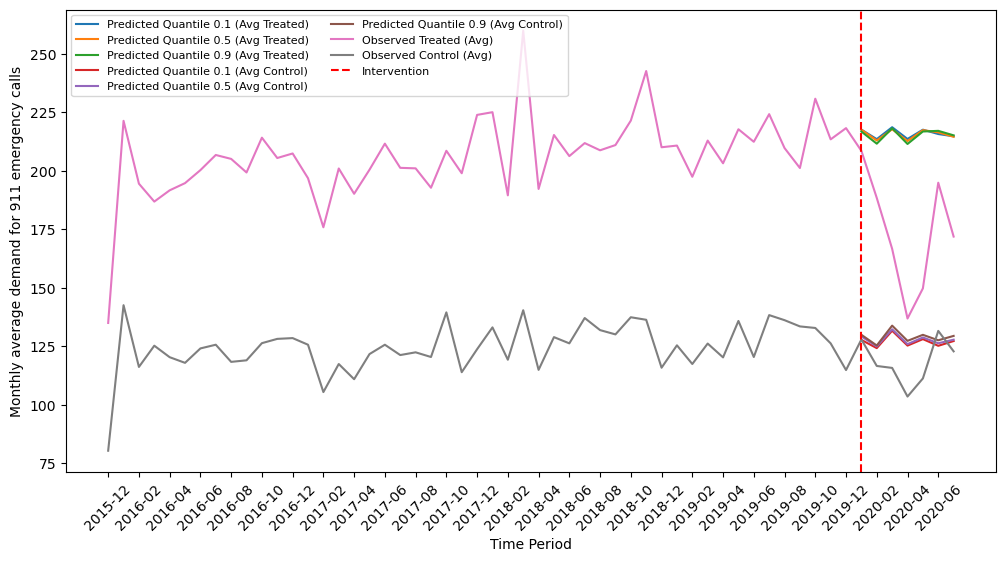

Treated Group - Mean: 19.398517897300415 Median: 19.888804920739663
Control Group - Mean: 8.525667853556655 Median: 6.665019663781571
Shapiro-Wilk test p-value for Treated Group: 0.8075667023658752
Shapiro-Wilk test p-value for Control Group: 0.5748091340065002
T-Test p-value: 0.003952851840901288


In [6]:
dataset_name = 'calls911_benchmarks'
data_type = 'calls911'
model = 'DeepProbCP'
forecast_horizon = 7
table2(dataset_name, data_type, model, forecast_horizon, plot_or_not=True)

In [68]:
dataset_name = 'sim_10_60_l_ho'
data_type = 'sim'
model = 'DeepProbCP'
forecast_horizon = 12
quantiles = ['0.1','0.5','0.9']
csv_files = {q: './results/nn_model_results/rnn/processed_ensemble_forecasts/'+dataset_name+'_LSTMcell_cocob_without_stl_decomposition_'\
                 +f'{q}.txt' for q in quantiles} 

# Create a dictionary to store the dataframes for each quantile
dfs = {q: [] for q in quantiles}

# Iterate over each quantile
for quantile, files in csv_files.items():
    # Iterate over each file for the quantile
    # Load the text data from CSV
    data = pd.read_csv(files, header=None)

    # Transpose the data for better visualization (units as rows, time periods as columns)
    transposed_data = data.transpose()

    # Append the transposed dataframe to the list for the current quantile
    dfs[quantile].append(transposed_data)

# Concatenate the dataframes along the columns (units) for each quantile
concatenated_data = {q: pd.concat(frames, axis=1) for q, frames in dfs.items()}
data_wor = pd.read_csv('./datasets/text_data/'+data_type+'/'+dataset_name+'.csv')
data_wr = pd.read_csv('./datasets/text_data/'+data_type+'/'+dataset_name+'_for_errors.csv').iloc[:,1:]
no_of_series = len(data_wor.columns)
length_of_series = len(data_wor.index)
actual_treated_orig_A = data_wr.iloc[length_of_series-forecast_horizon:, int(no_of_series-int((no_of_series)/2))-1:]
data_index = data_wor
tnc = [0] * int((no_of_series)/2) +\
    [1] * int(no_of_series-int((no_of_series)/2))
actual_treated_orig_A = data_wr.iloc[length_of_series-forecast_horizon:, int(no_of_series-int((no_of_series)/2))-1:]
data_index = data_wor
# a boolean list to denote whether the unit is treated or controled
tnc_bool = [bool(value) for value in tnc]
flipped_tnc_bool = [not value for value in tnc_bool]
actual_treated_intervened = data_index[data_index.columns[tnc_bool]]
actual_treated_intervened_A = actual_treated_intervened.iloc[-forecast_horizon:, :]

smoothed_pred = concatenated_data['0.5'][concatenated_data['0.5'].columns[tnc_bool]].iloc[-forecast_horizon:, :]
smoothed_pred.index = actual_treated_intervened_A.index

In [69]:
quantile_90_orig = actual_treated_orig_A.apply(lambda row: row.quantile([0.9]), axis=1)
quantile_90_actual = actual_treated_intervened_A.apply(lambda row: row.quantile([0.9]), axis=1)
quantile_90_pred = smoothed_pred.apply(lambda row: row.quantile([0.9]), axis=1)
smoothed_pred

5         6         7          8         9
48  6.491814  5.289264  9.342193  10.035085  6.528339
49  6.641221  5.268043  9.153724   9.688393  6.267400
50  7.152164  5.685464  8.687524   9.356777  5.793505
51  7.675734  6.012766  8.122985   8.651508  5.280974
52  7.999962  6.141273  7.767976   8.160968  5.046241
53  7.578219  5.942590  7.480276   8.153823  5.054816
54  7.332952  5.531044  7.050724   8.373165  4.907351
55  6.723883  5.136585  6.914015   8.667336  5.128565
56  6.370902  4.824399  6.774146   9.033715  5.215010
57  6.289500  4.653143  6.742062   9.272333  5.257648
58  6.413086  4.754886  6.629057   9.857418  5.178199
59  6.819925  4.836958  6.599220  10.352241  5.012428

In [73]:
# print(quantile_90_actual,quantile_90_orig)
# print(actual_treated_intervened_A)
# print(actual_treated_orig_A)
tte_90_true = actual_treated_intervened_A[actual_treated_intervened_A.gt(np.array(quantile_90_actual), axis=1)].mean(axis=1) - \
                    actual_treated_orig_A[actual_treated_orig_A.gt(np.array(quantile_90_orig), axis=1)].mean(axis=1)
tte_90_pred = actual_treated_intervened_A[actual_treated_intervened_A.gt(np.array(quantile_90_actual), axis=1)].mean(axis=1) - \
                    smoothed_pred[smoothed_pred.gt(np.array(quantile_90_pred), axis=1)].mean(axis=1)

In [77]:
#### SMAPE
time_series_wise_SMAPE = 2 * np.abs(np.array(tte_90_true)\
                                        - np.array(tte_90_pred)) /\
    (np.abs(np.array(tte_90_true))\
        + np.abs(np.array(tte_90_pred)))
mean_SMAPE = np.mean(time_series_wise_SMAPE)
mean_SMAPE_str = f"mean_SMAPE for TTE :{mean_SMAPE}"
print(mean_SMAPE_str)

[2.         1.88076205 1.0263589  0.00334311 0.22615759 2.
 0.29366796 2.         0.4366037  0.57308059 1.15475603 2.        ]
mean_SMAPE for TTE :1.132894160748083


calls911_benchmarks
(7, 62)
Average Treatment Effect for q > 10%:  -32.72094475650138
Average Treatment Effect for q > 50%:  -43.87830221240654
Average Treatment Effect for q > 90%:  -126.39763051131854


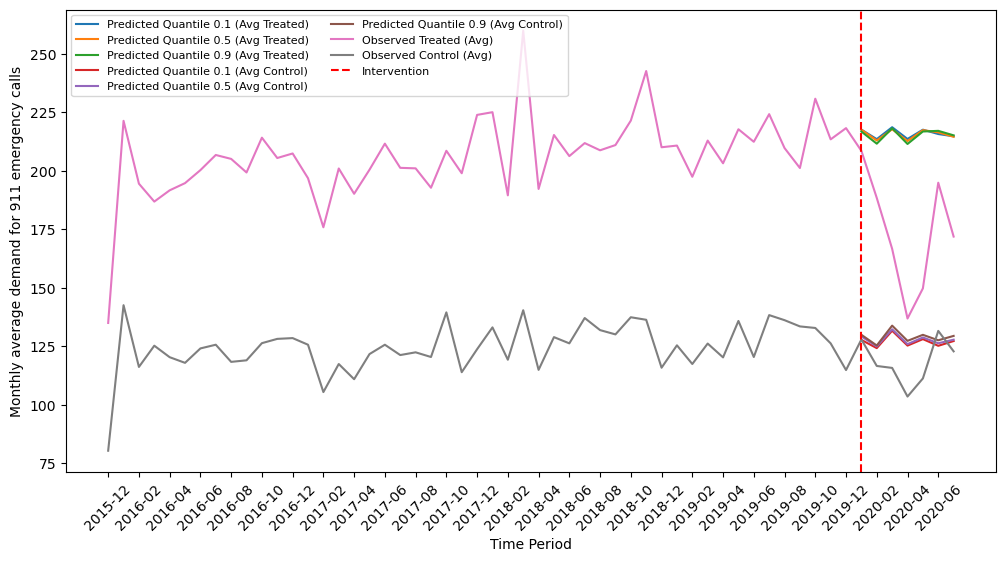

Treated Group - Mean: 19.398517897300415 Median: 19.888804920739663
Control Group - Mean: 8.525667853556655 Median: 6.665019663781571
Shapiro-Wilk test p-value for Treated Group: 0.8075667023658752
Shapiro-Wilk test p-value for Control Group: 0.5748091340065002
T-Test p-value: 0.003952851840901288
 
sim_10_60_l_ho
(12, 10)
10
True Average Treatement Effect for q > 90%: :  2.028136302220142
Average Treatment Effect for q > 90%:  -0.15257109634313082
Relative Difference for TTE : -1.0752272399917677


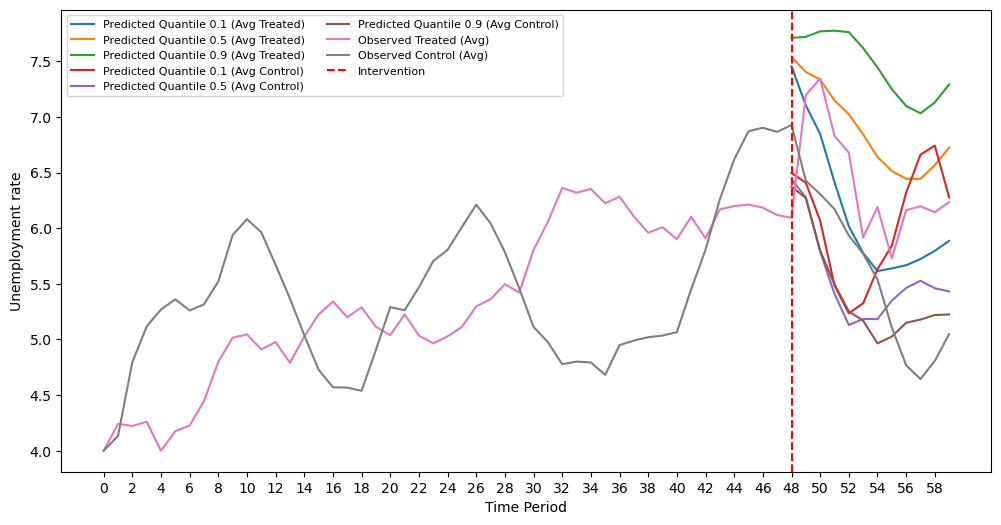

Treated Group - Mean: 7.14631838530789 Median: 5.68097112512448
Control Group - Mean: 9.920601541103162 Median: 10.11711289123157
Shapiro-Wilk test p-value for Treated Group: 0.14308686554431915
Shapiro-Wilk test p-value for Control Group: 0.7659654021263123
T-Test p-value: 0.23281270550210023
 
sim_10_60_nl_ho
(12, 10)
10
True Average Treatement Effect for q > 90%: :  3.411237033498434
Average Treatment Effect for q > 90%:  6.964169188476142
Relative Difference for TTE : 1.041537753046131


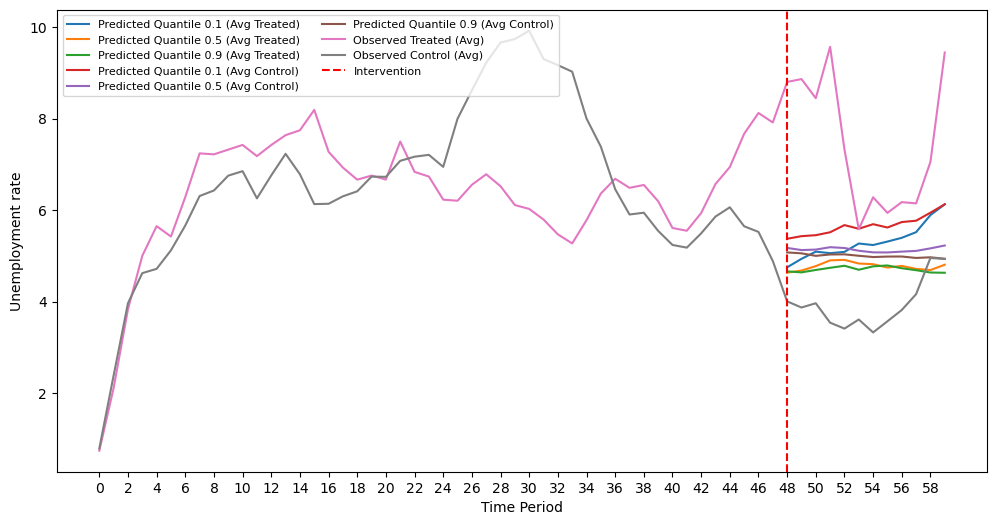

Treated Group - Mean: 56.480249473222834 Median: 49.73986710110492
Control Group - Mean: 23.536053256792048 Median: 24.76199226167526
Shapiro-Wilk test p-value for Treated Group: 0.05435645207762718
Shapiro-Wilk test p-value for Control Group: 0.06859075278043747
T-Test p-value: 0.00791226776152495
 
sim_10_222_l_ho
(12, 10)
10
True Average Treatement Effect for q > 90%: :  2.8330899104518323
Average Treatment Effect for q > 90%:  3.0910193213138477
Relative Difference for TTE : 0.09104173147151541


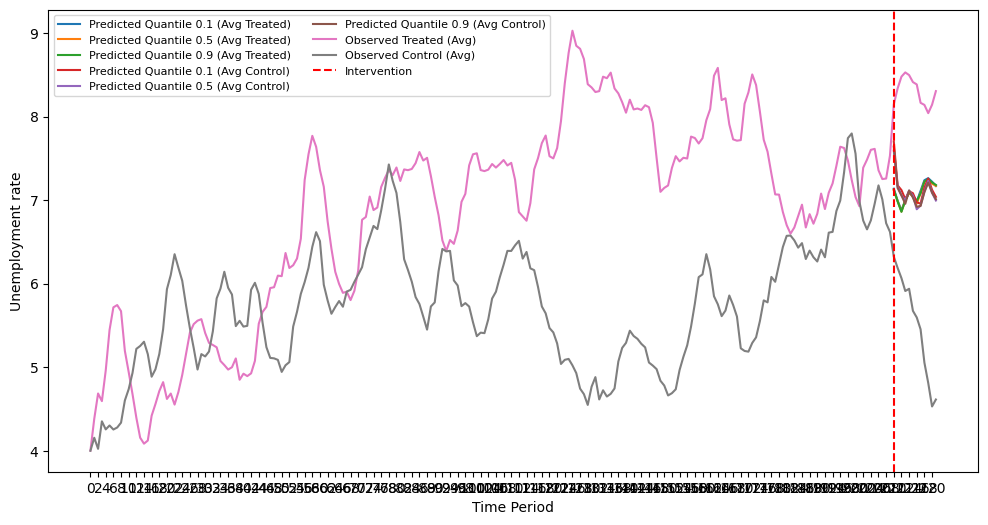

Treated Group - Mean: 17.26794222114833 Median: 17.56447828539934
Control Group - Mean: 22.38056592158271 Median: 19.172194969708258
Shapiro-Wilk test p-value for Treated Group: 0.5826295018196106
Shapiro-Wilk test p-value for Control Group: 0.03606397286057472
Wilcoxon test p-value: 0.33935546875
 
sim_10_222_nl_ho
(12, 10)
10
True Average Treatement Effect for q > 90%: :  3.2519035864720003
Average Treatment Effect for q > 90%:  0.6485928558051679
Relative Difference for TTE : -0.8005497892055194


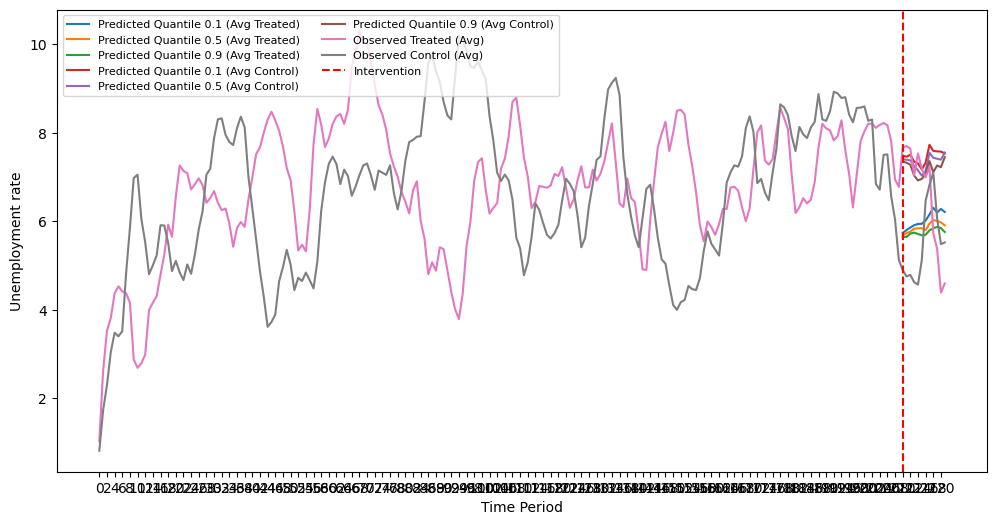

Treated Group - Mean: 23.413179389093557 Median: 22.630508569106937
Control Group - Mean: 24.870603872191356 Median: 27.038059340025434
Shapiro-Wilk test p-value for Treated Group: 0.3599071204662323
Shapiro-Wilk test p-value for Control Group: 0.04262544959783554
Wilcoxon test p-value: 0.38037109375
 
sim_101_60_l_ho
(12, 101)
101
True Average Treatement Effect for q > 90%: :  2.1949481346319484
Average Treatment Effect for q > 90%:  1.2830596342473122
Relative Difference for TTE : -0.41544876892389204


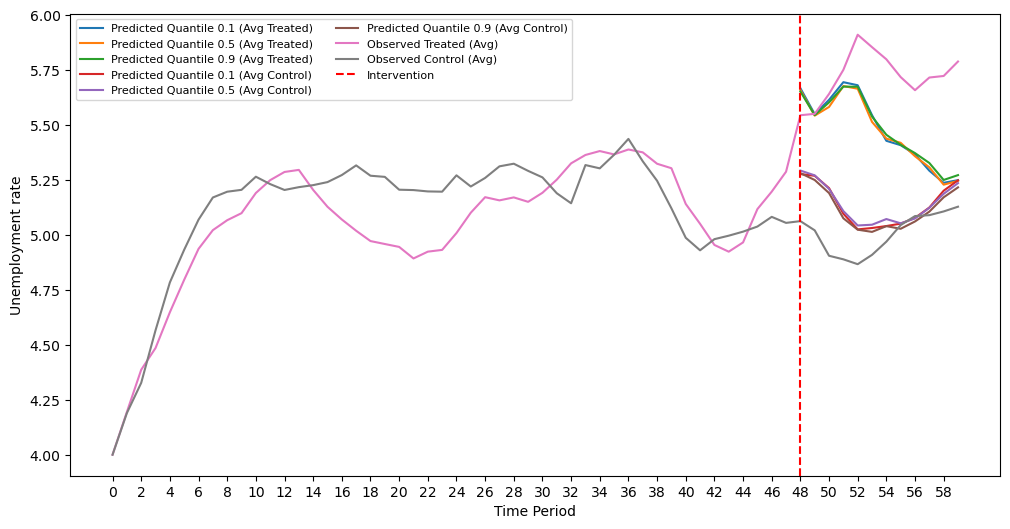

Treated Group - Mean: 5.02522121309923 Median: 5.562546392973071
Control Group - Mean: 2.6739382934457256 Median: 2.3836179636107984
Shapiro-Wilk test p-value for Treated Group: 0.6262862086296082
Shapiro-Wilk test p-value for Control Group: 0.6043128967285156
T-Test p-value: 0.12517119894775017
 
sim_101_60_nl_ho
(12, 101)
101
True Average Treatement Effect for q > 90%: :  3.327162362729842
Average Treatment Effect for q > 90%:  0.9900389563235006
Relative Difference for TTE : -0.7024374381563989


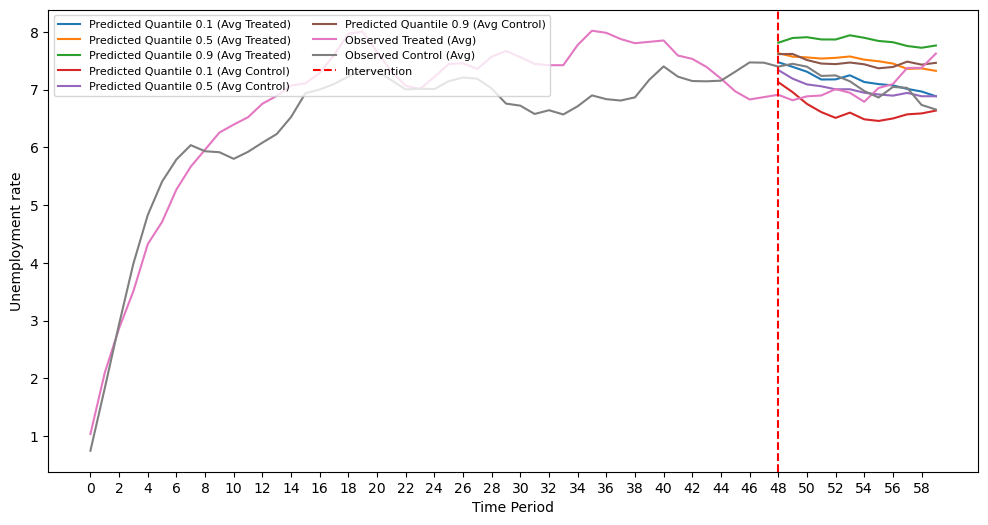

Treated Group - Mean: 6.450129595428503 Median: 7.7316724099370155
Control Group - Mean: 2.233506392408263 Median: 2.1844202143386053
Shapiro-Wilk test p-value for Treated Group: 0.04871198162436485
Shapiro-Wilk test p-value for Control Group: 0.6425687074661255
Wilcoxon test p-value: 0.0048828125
 
sim_101_222_l_ho
(12, 101)
101
True Average Treatement Effect for q > 90%: :  2.645064484886211
Average Treatment Effect for q > 90%:  2.6779789612760947
Relative Difference for TTE : 0.012443733065093813


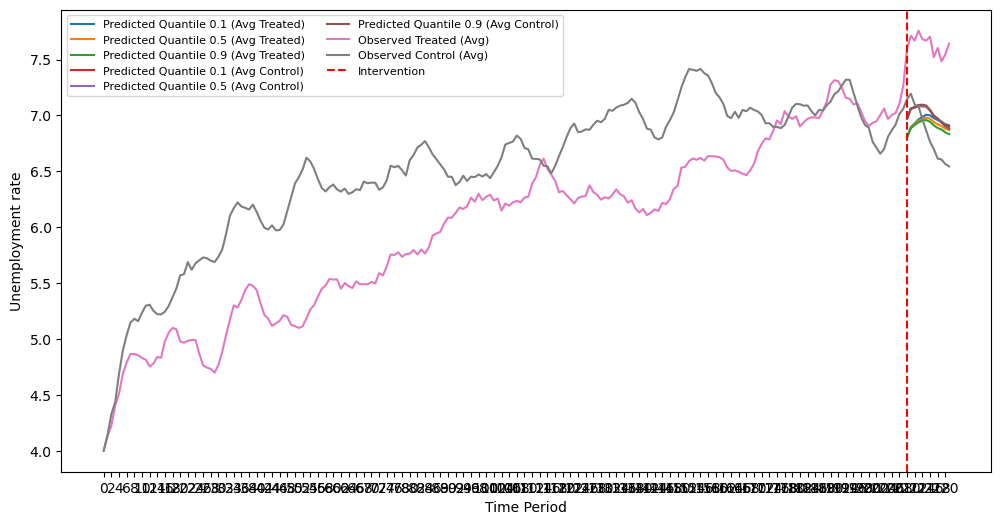

Treated Group - Mean: 10.350702703924021 Median: 10.399335834425084
Control Group - Mean: 3.125764668006323 Median: 3.5259579408448674
Shapiro-Wilk test p-value for Treated Group: 0.3784087300300598
Shapiro-Wilk test p-value for Control Group: 0.12231338024139404
T-Test p-value: 1.465725465174764e-06
 
sim_101_222_nl_ho
(12, 101)
101
True Average Treatement Effect for q > 90%: :  3.0956541577302445
Average Treatment Effect for q > 90%:  2.9214140233149237
Relative Difference for TTE : -0.0562854006091801


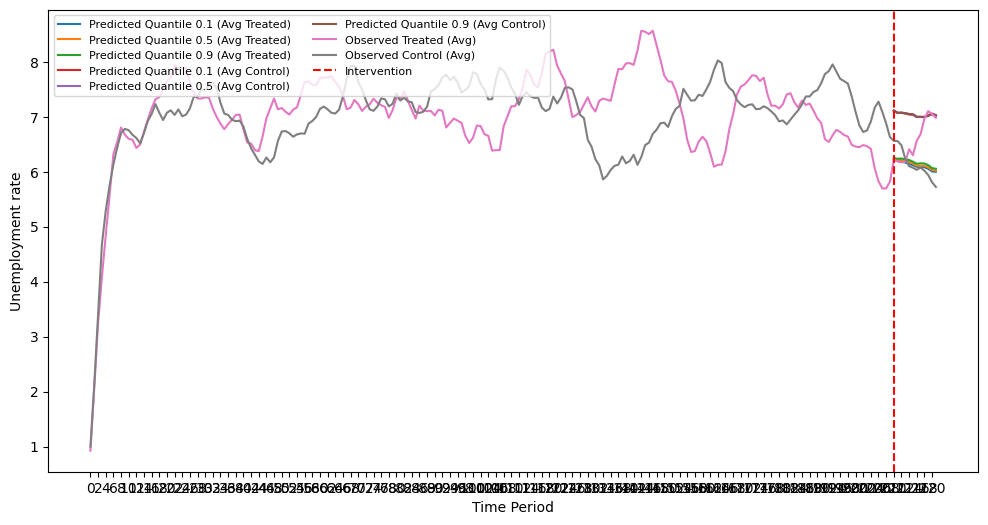

Treated Group - Mean: 7.362939119733735 Median: 5.585367098494807
Control Group - Mean: 12.88876203494914 Median: 13.570119108374012
Shapiro-Wilk test p-value for Treated Group: 0.024866359308362007
Shapiro-Wilk test p-value for Control Group: 0.3460095524787903
Wilcoxon test p-value: 0.00341796875
 
sim_500_60_l_ho
(12, 500)
500
True Average Treatement Effect for q > 90%: :  2.2892476702492868
Average Treatment Effect for q > 90%:  1.7288227101484956
Relative Difference for TTE : -0.24480748299277022


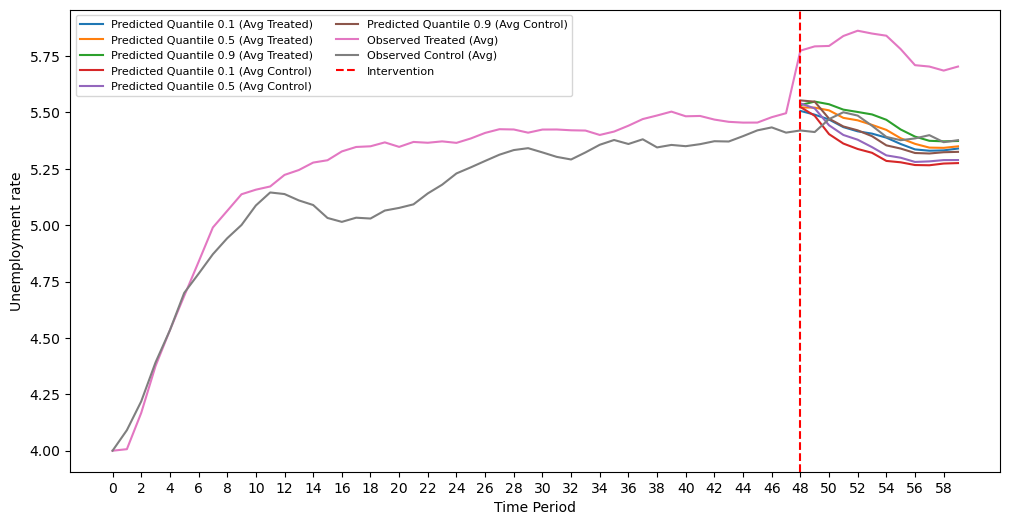

Treated Group - Mean: 6.442936668066999 Median: 6.623411416458585
Control Group - Mean: 1.712227237597715 Median: 1.8188962878897903
Shapiro-Wilk test p-value for Treated Group: 0.11374864727258682
Shapiro-Wilk test p-value for Control Group: 0.02266007289290428
Wilcoxon test p-value: 0.00048828125
 
sim_500_60_nl_ho
(12, 500)
500
True Average Treatement Effect for q > 90%: :  3.318771344593099
Average Treatment Effect for q > 90%:  2.4871185455442024
Relative Difference for TTE : -0.25059056882717


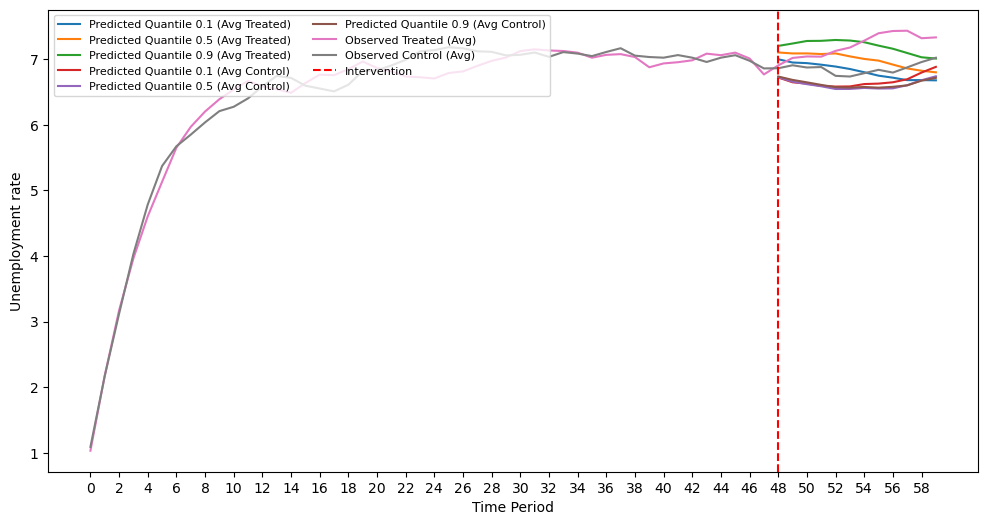

Treated Group - Mean: 4.0222439079870265 Median: 3.3790952060946817
Control Group - Mean: 3.662272151836327 Median: 3.7966921581938093
Shapiro-Wilk test p-value for Treated Group: 0.04338759183883667
Shapiro-Wilk test p-value for Control Group: 0.17635351419448853
Wilcoxon test p-value: 0.67724609375
 
sim_500_222_l_ho
(12, 500)
500
True Average Treatement Effect for q > 90%: :  2.6023627682178567
Average Treatment Effect for q > 90%:  1.5251715046149812
Relative Difference for TTE : -0.41392817202828136


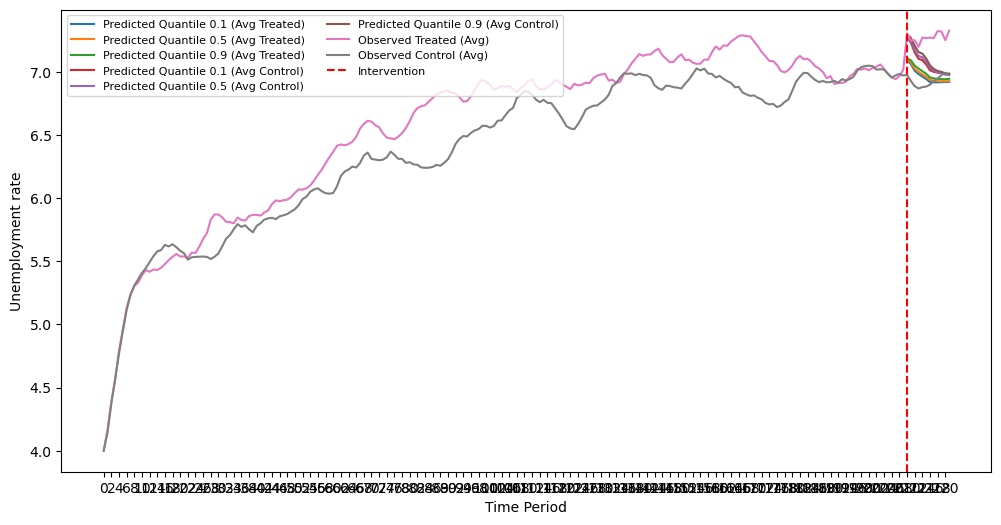

Treated Group - Mean: 4.301235355721173 Median: 4.561553132865653
Control Group - Mean: 2.208919200790223 Median: 2.3293211284256583
Shapiro-Wilk test p-value for Treated Group: 0.19621053338050842
Shapiro-Wilk test p-value for Control Group: 0.11292150616645813
T-Test p-value: 0.026748771018189708
 
sim_500_222_nl_ho
(12, 500)
500
True Average Treatement Effect for q > 90%: :  3.208387450656046
Average Treatment Effect for q > 90%:  3.3530801902813696
Relative Difference for TTE : 0.045098275021533685


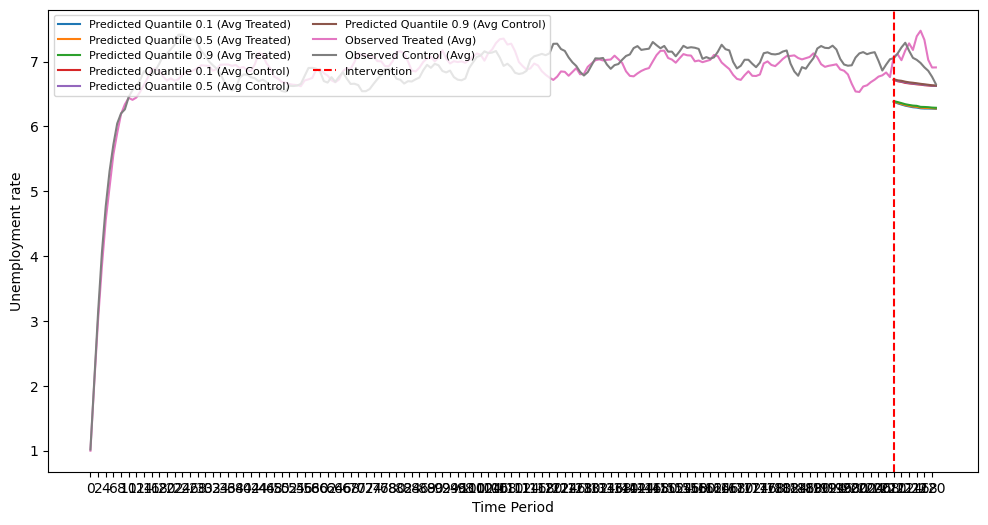

Treated Group - Mean: 13.368278429823802 Median: 12.544525471930756
Control Group - Mean: 5.170386360094995 Median: 5.2642306704383355
Shapiro-Wilk test p-value for Treated Group: 0.2261284738779068
Shapiro-Wilk test p-value for Control Group: 0.996844470500946
T-Test p-value: 3.962826381116997e-06
 
sim_10_60_l_he
(12, 10)
10
True Average Treatement Effect for q > 90%: :  1.1740371397548763
Average Treatment Effect for q > 90%:  1.0696356285577195
Relative Difference for TTE : -0.08892522021829265


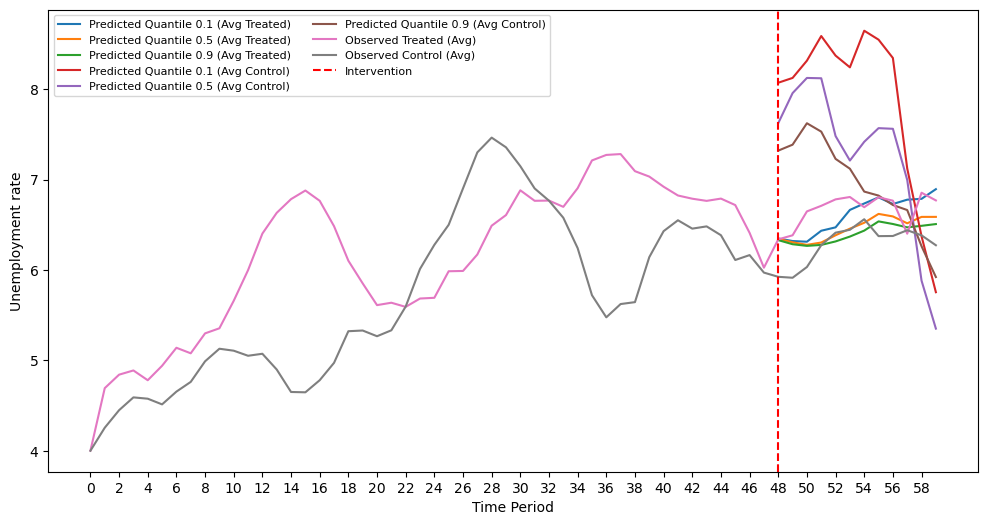

Treated Group - Mean: 3.4968345914544607 Median: 2.775580295407287
Control Group - Mean: 16.508838436029524 Median: 15.733743316486187
Shapiro-Wilk test p-value for Treated Group: 0.34933382272720337
Shapiro-Wilk test p-value for Control Group: 0.3237222731113434
T-Test p-value: 3.349053639433633e-05
 
sim_10_60_nl_he
(12, 10)
10
True Average Treatement Effect for q > 90%: :  4.3324453738500655
Average Treatment Effect for q > 90%:  3.1204607481723716
Relative Difference for TTE : -0.27974608358435066


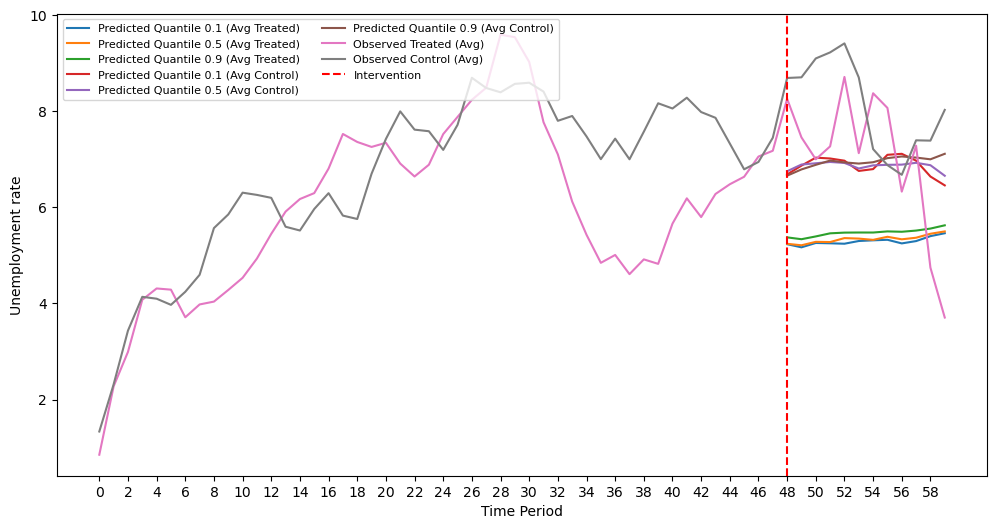

Treated Group - Mean: 39.46579911142123 Median: 36.6997073909197
Control Group - Mean: 18.8398250700014 Median: 23.46277396415835
Shapiro-Wilk test p-value for Treated Group: 0.6612281799316406
Shapiro-Wilk test p-value for Control Group: 0.06944043934345245
T-Test p-value: 0.0015716093770814057
 
sim_10_222_l_he
(12, 10)
10
True Average Treatement Effect for q > 90%: :  0.5032048566319478
Average Treatment Effect for q > 90%:  0.3488651357878503
Relative Difference for TTE : -0.30671349612387405


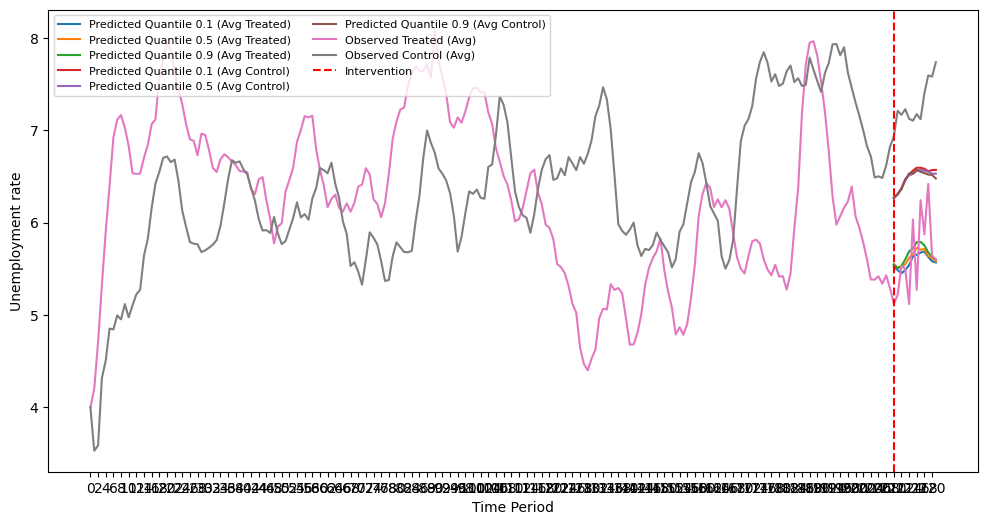

Treated Group - Mean: 5.3749627565874505 Median: 5.944945336975612
Control Group - Mean: 12.364991114053778 Median: 12.11226033182286
Shapiro-Wilk test p-value for Treated Group: 0.22015997767448425
Shapiro-Wilk test p-value for Control Group: 0.46164602041244507
T-Test p-value: 0.0030904889713522167
 
sim_10_222_nl_he
(12, 10)
10
True Average Treatement Effect for q > 90%: :  2.6488220830159985
Average Treatment Effect for q > 90%:  3.659520358080819
Relative Difference for TTE : 0.38156518006449885


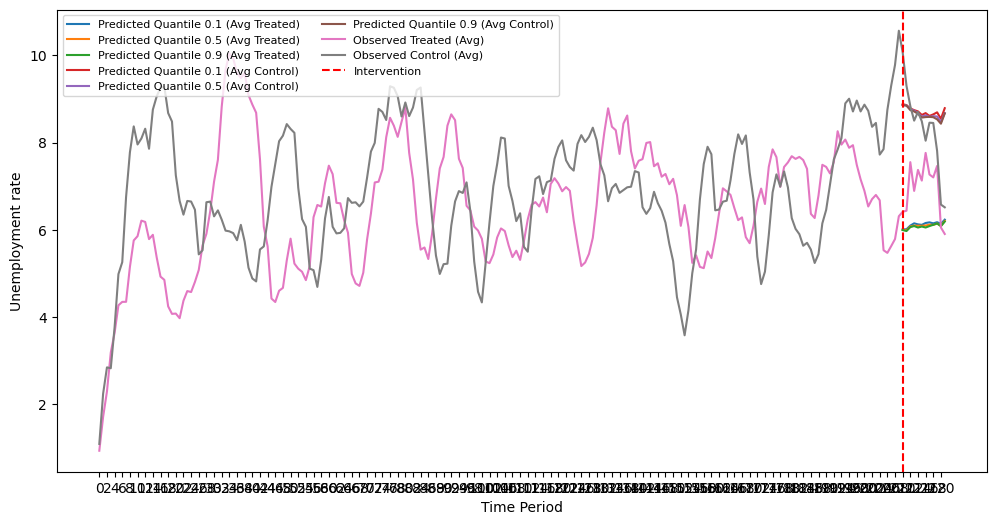

Treated Group - Mean: 15.04000951998151 Median: 17.41028536388683
Control Group - Mean: 7.512954417891777 Median: 3.8444318845209677
Shapiro-Wilk test p-value for Treated Group: 0.642418384552002
Shapiro-Wilk test p-value for Control Group: 0.009804795496165752
Wilcoxon test p-value: 0.17626953125
 
sim_101_60_l_he
(12, 101)
101
True Average Treatement Effect for q > 90%: :  3.2763818223572745
Average Treatment Effect for q > 90%:  4.014390200506849
Relative Difference for TTE : 0.2252510293866165


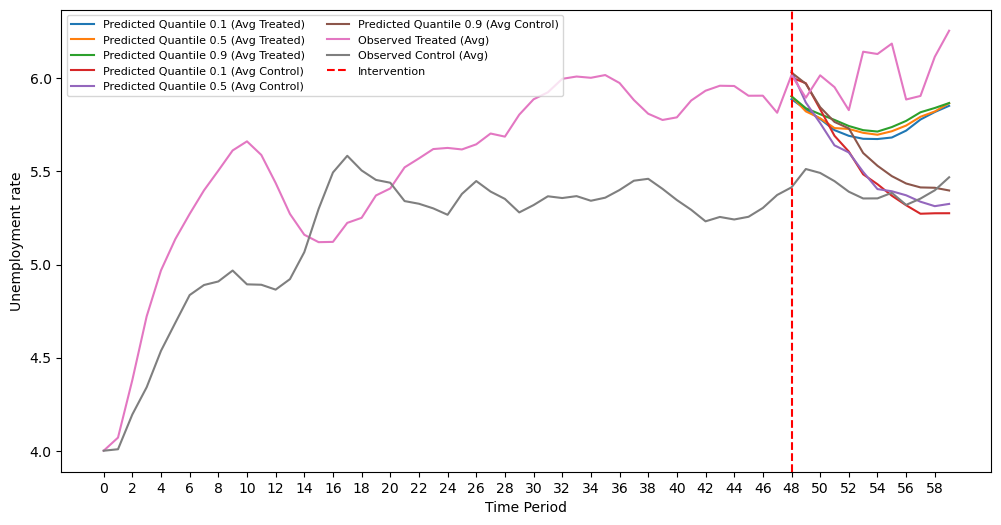

Treated Group - Mean: 4.358110453789057 Median: 3.911621685831517
Control Group - Mean: 3.123404775907637 Median: 2.6414789367020486
Shapiro-Wilk test p-value for Treated Group: 0.0973445251584053
Shapiro-Wilk test p-value for Control Group: 0.06721775978803635
T-Test p-value: 0.3867692198231929
 
sim_101_60_nl_he
(12, 101)
101
True Average Treatement Effect for q > 90%: :  3.3947834764177163
Average Treatment Effect for q > 90%:  2.573966842401564
Relative Difference for TTE : -0.24178762495989997


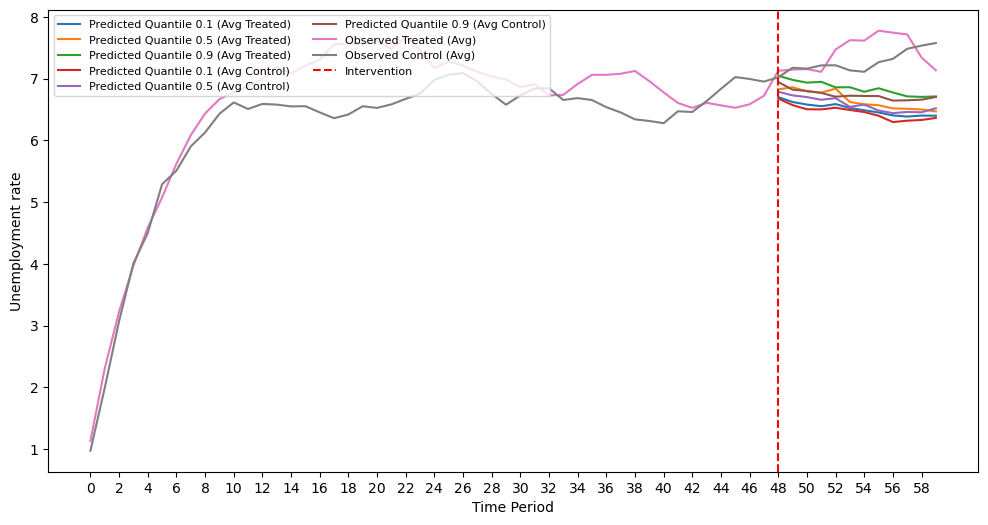

Treated Group - Mean: 11.482976420667157 Median: 11.612214738090564
Control Group - Mean: 10.406655173382187 Median: 8.697711481275384
Shapiro-Wilk test p-value for Treated Group: 0.08245905488729477
Shapiro-Wilk test p-value for Control Group: 0.2694462835788727
T-Test p-value: 0.42857667965765844
 
sim_101_222_l_he
(12, 101)
101
True Average Treatement Effect for q > 90%: :  2.4574868995157306
Average Treatment Effect for q > 90%:  3.0688605013744734
Relative Difference for TTE : 0.24878000447498594


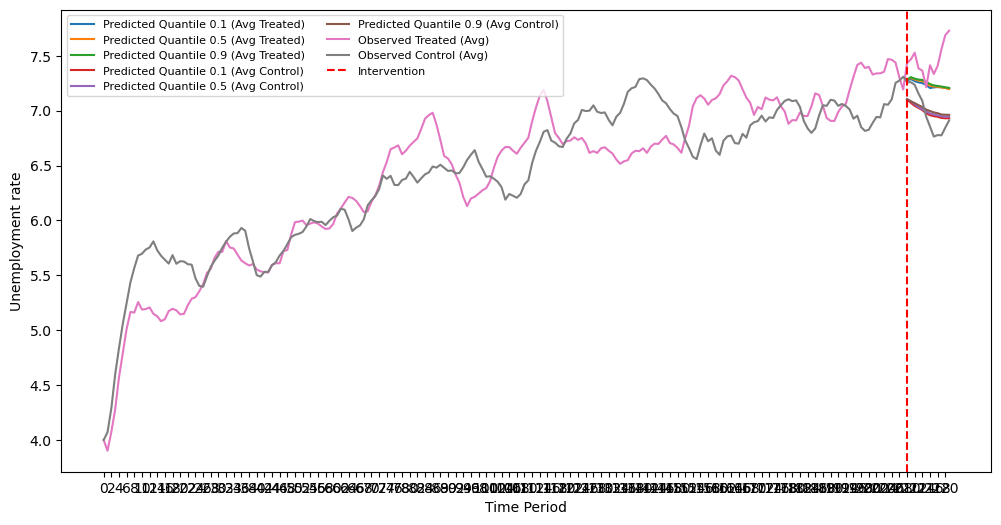

Treated Group - Mean: 3.066578571263515 Median: 2.4537182384556457
Control Group - Mean: 1.8584124267445257 Median: 1.9689937131099184
Shapiro-Wilk test p-value for Treated Group: 0.06500251591205597
Shapiro-Wilk test p-value for Control Group: 0.2959732115268707
T-Test p-value: 0.11599068266147346
 
sim_101_222_nl_he
(12, 101)
101
True Average Treatement Effect for q > 90%: :  4.356385685996122
Average Treatment Effect for q > 90%:  4.235450100395731
Relative Difference for TTE : -0.02776053231217469


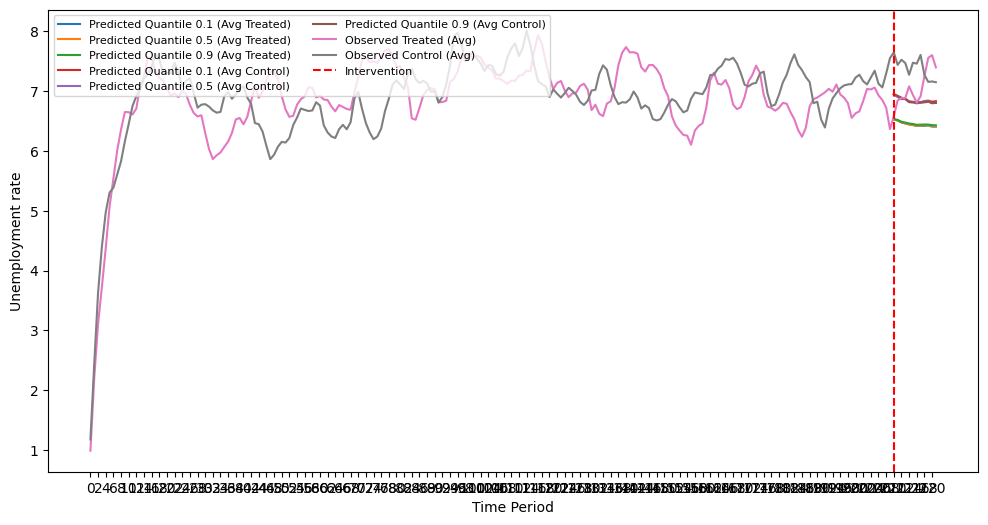

Treated Group - Mean: 9.497394994935313 Median: 7.674446402045461
Control Group - Mean: 7.940024311164861 Median: 8.17894858441607
Shapiro-Wilk test p-value for Treated Group: 0.3871399760246277
Shapiro-Wilk test p-value for Control Group: 0.5480363965034485
T-Test p-value: 0.48128980434214597
 
sim_500_60_l_he
(12, 500)
500
True Average Treatement Effect for q > 90%: :  1.5607094795875955
Average Treatment Effect for q > 90%:  1.4500098269315735
Relative Difference for TTE : -0.07092905765221177


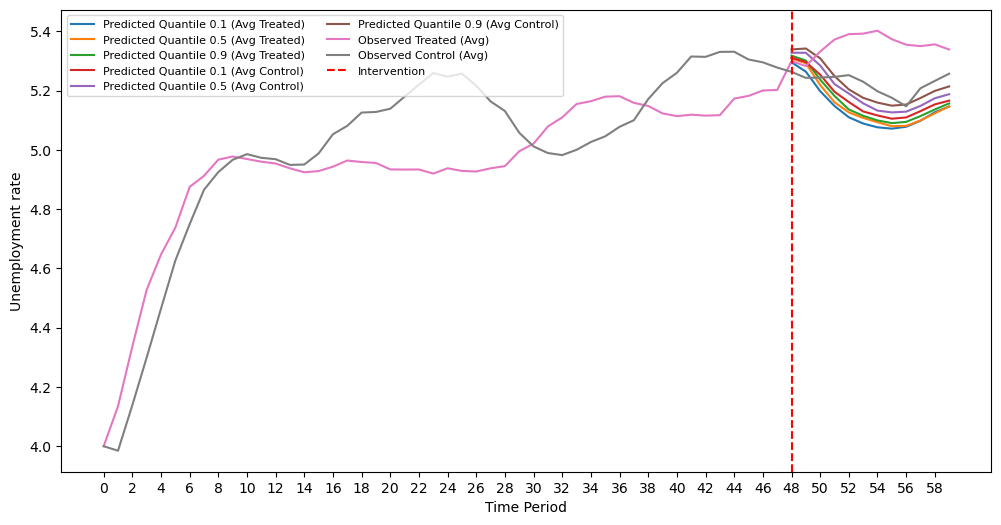

Treated Group - Mean: 3.979407520831425 Median: 4.729175682031935
Control Group - Mean: 1.0719938188030596 Median: 1.1770468245404047
Shapiro-Wilk test p-value for Treated Group: 0.02326052635908127
Shapiro-Wilk test p-value for Control Group: 0.2500048875808716
Wilcoxon test p-value: 0.00341796875
 
sim_500_60_nl_he
(12, 500)
500
True Average Treatement Effect for q > 90%: :  2.295530645707709
Average Treatment Effect for q > 90%:  1.868329478964684
Relative Difference for TTE : -0.18610126923891246


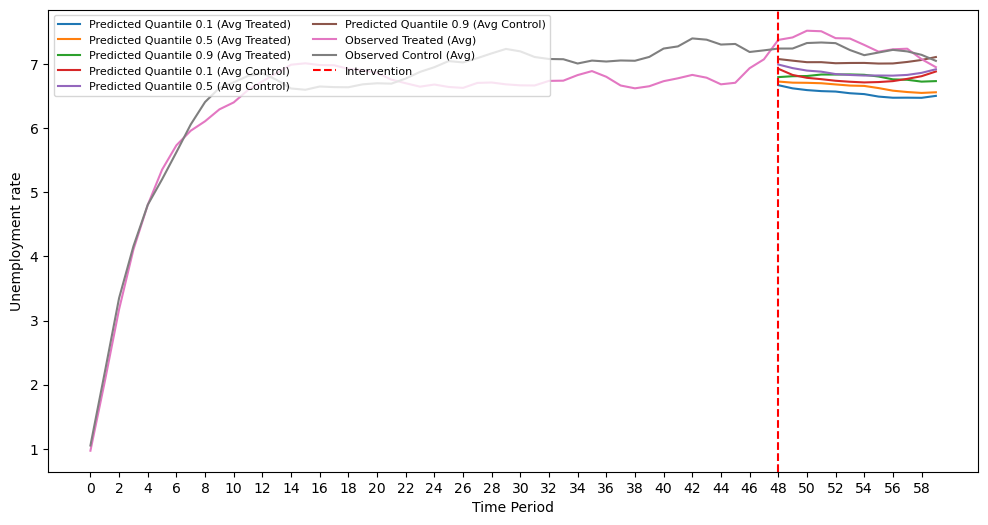

Treated Group - Mean: 9.86945536789177 Median: 10.042492127748478
Control Group - Mean: 5.05897396128596 Median: 5.314852469328356
Shapiro-Wilk test p-value for Treated Group: 0.4541682302951813
Shapiro-Wilk test p-value for Control Group: 0.77852863073349
T-Test p-value: 3.252666083529835e-09
 
sim_500_222_l_he
(12, 500)
500
True Average Treatement Effect for q > 90%: :  2.172311804073887
Average Treatment Effect for q > 90%:  1.7251139962652111
Relative Difference for TTE : -0.20586262385078188


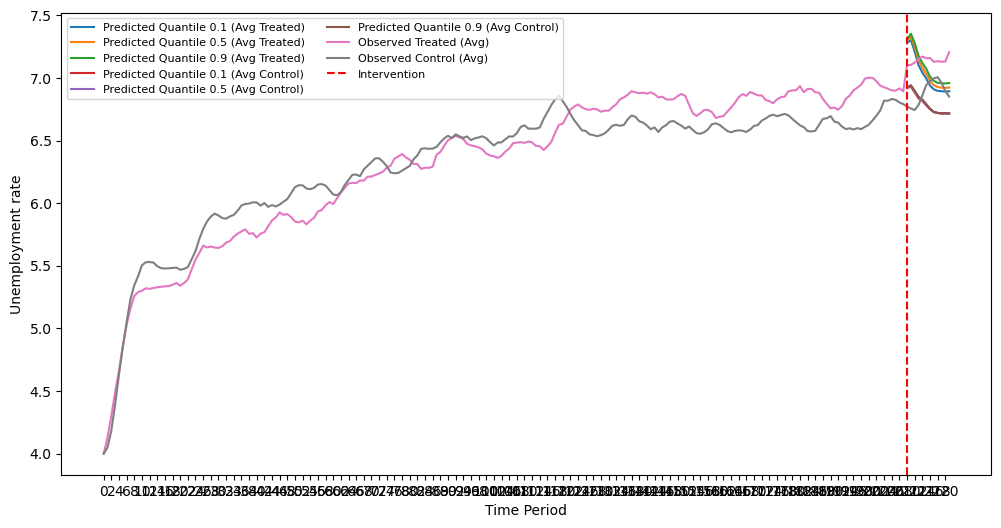

Treated Group - Mean: 2.414335936476807 Median: 2.684747158112849
Control Group - Mean: 2.548371607796756 Median: 2.438903617006053
Shapiro-Wilk test p-value for Treated Group: 0.26035913825035095
Shapiro-Wilk test p-value for Control Group: 0.7096280455589294
T-Test p-value: 0.6423337959484142
 
sim_500_222_nl_he
(12, 500)
500
True Average Treatement Effect for q > 90%: :  2.890799046442247
Average Treatment Effect for q > 90%:  1.9398169599433128
Relative Difference for TTE : -0.32896859007523305


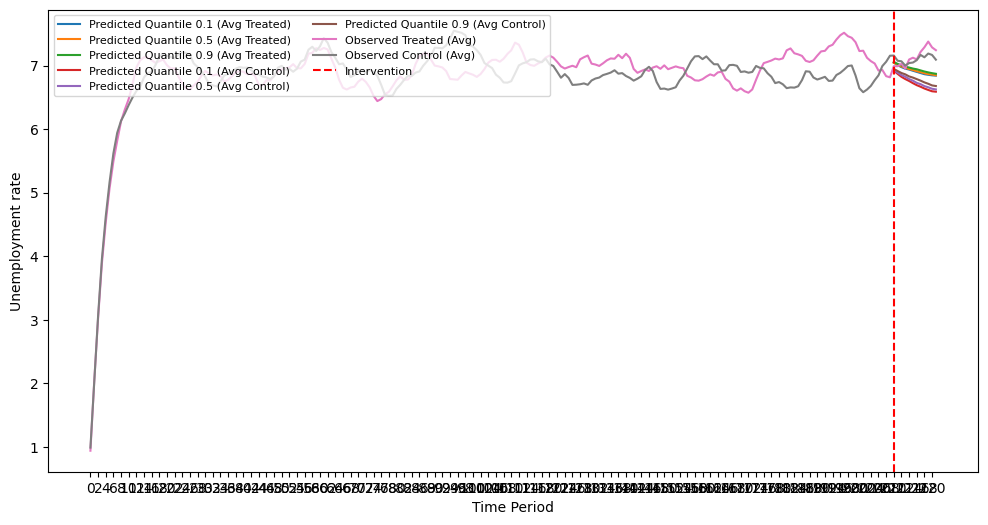

Treated Group - Mean: 3.2918344494935305 Median: 2.736936433466953
Control Group - Mean: 5.147748036297424 Median: 4.770986203080188
Shapiro-Wilk test p-value for Treated Group: 0.1674053817987442
Shapiro-Wilk test p-value for Control Group: 0.0944291204214096
T-Test p-value: 2.297679964215454e-06
 


In [28]:
dataset_name_test = ['calls911_benchmarks',\
                     'sim_10_60_l_ho','sim_10_60_nl_ho',\
                     'sim_10_222_l_ho','sim_10_222_nl_ho',\
                     'sim_101_60_l_ho', 'sim_101_60_nl_ho',\
                     'sim_101_222_l_ho', 'sim_101_222_nl_ho',\
                     'sim_500_60_l_ho', 'sim_500_60_nl_ho',\
                     'sim_500_222_l_ho', 'sim_500_222_nl_ho',\
                     'sim_10_60_l_he', 'sim_10_60_nl_he',\
                     'sim_10_222_l_he', 'sim_10_222_nl_he',\
                     'sim_101_60_l_he', 'sim_101_60_nl_he',\
                     'sim_101_222_l_he', 'sim_101_222_nl_he',\
                     'sim_500_60_l_he', 'sim_500_60_nl_he',\
                     'sim_500_222_l_he', 'sim_500_222_nl_he']
data_type = ['calls911'] + ['sim']*24
forecast_horizon = [7] + [12]*24
model = 'DeepProbCP'
for i in range(len(dataset_name_test)):
    print(dataset_name_test[i])
    table2(dataset_name_test[i], data_type[i], model, forecast_horizon[i], plot_or_not=True)
    print(" ")

In [29]:
dataset_name_test = ['calls911_benchmarks',\
                     'sim_10_60_l_ho','sim_10_60_nl_ho',\
                     'sim_10_222_l_ho','sim_10_222_nl_ho',\
                     'sim_101_60_l_ho', 'sim_101_60_nl_ho',\
                     'sim_101_222_l_ho', 'sim_101_222_nl_ho',\
                     'sim_500_60_l_ho', 'sim_500_60_nl_ho',\
                     'sim_500_222_l_ho', 'sim_500_222_nl_ho',\
                     'sim_10_60_l_he', 'sim_10_60_nl_he',\
                     'sim_10_222_l_he', 'sim_10_222_nl_he',\
                     'sim_101_60_l_he', 'sim_101_60_nl_he',\
                     'sim_101_222_l_he', 'sim_101_222_nl_he',\
                     'sim_500_60_l_he', 'sim_500_60_nl_he',\
                     'sim_500_222_l_he', 'sim_500_222_nl_he']
data_type = ['calls911'] + ['sim']*24
te = [None] + ['homogeneous']*12 + ['heterogeneous']*12
model = 'causalimpact'
for i in range(len(dataset_name_test)):
    print(dataset_name_test[i])
    table2(dataset_name_test[i], data_type[i], model, te[i], plot_or_not=True)
    print(" ")

calls911_benchmarks


TypeError: bad operand type for unary -: 'NoneType'

calls911_benchmarks
Average Treatment Effect for q > 10%:  -31.000996234206298
Average Treatment Effect for q > 50%:  67.5818657762469
Average Treatment Effect for q > 90%:  324.508864580517


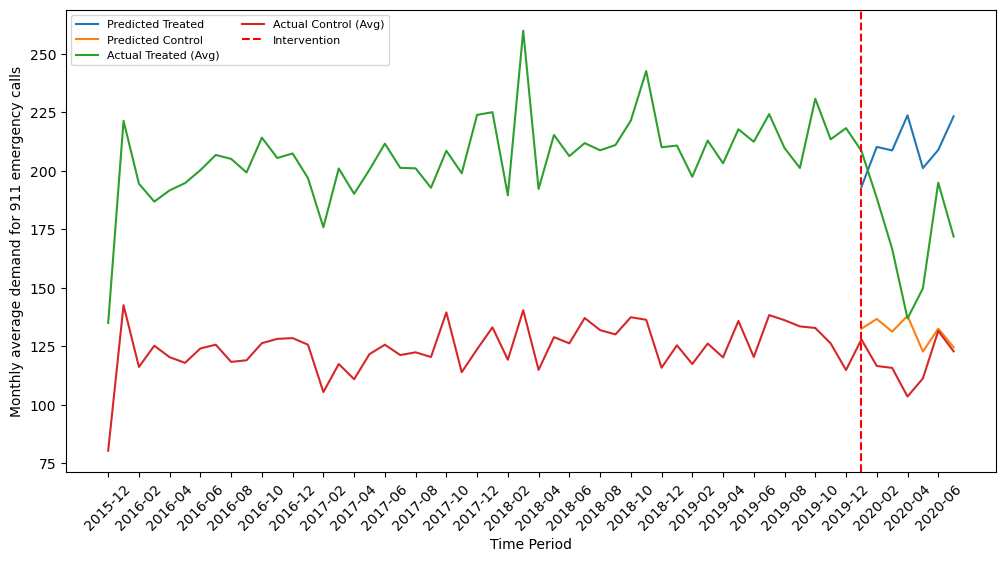

Treated Group - Mean: 18.955598146312514 Median: 20.15967353608337
Control Group - Mean: 9.500954519034469 Median: 9.361239727317702
Shapiro-Wilk test p-value for Treated Group: 0.4646078646183014
Shapiro-Wilk test p-value for Control Group: 0.43220922350883484
T-Test p-value: 0.026611734173785127
 
sim_10_60_l_ho
True Average Treatement Effect for q > 90%: :  1.8151073716283772
Average Treatment Effect for q > 90%:  -5.75853561823727
Relative Difference for TTE : -4.1725592150899296


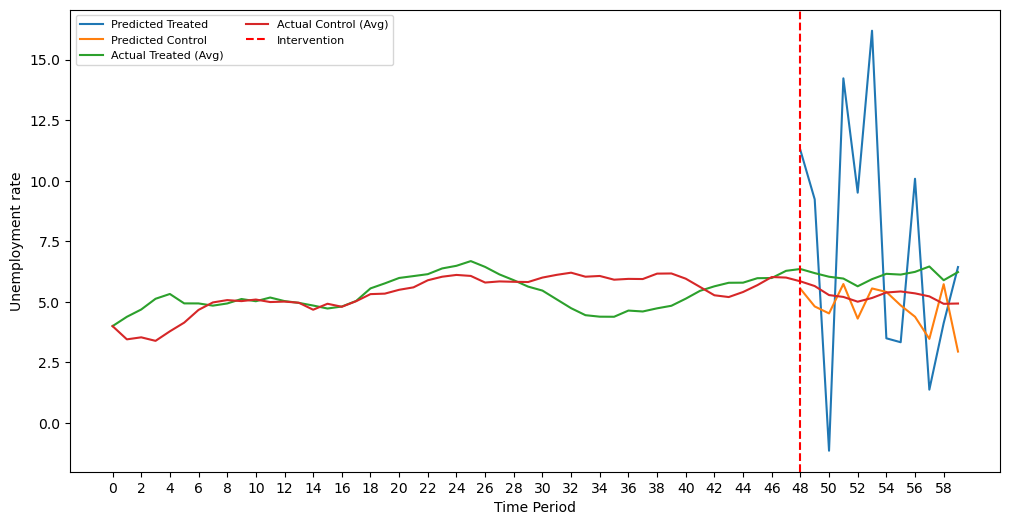

Treated Group - Mean: 18.62222105173605 Median: 43.244683644568866
Control Group - Mean: 19.873891020606447 Median: 15.169837327321094
Shapiro-Wilk test p-value for Treated Group: 0.00017170578939840198
Shapiro-Wilk test p-value for Control Group: 0.004886934068053961
Wilcoxon test p-value: 0.1513671875
 
sim_10_60_nl_ho
True Average Treatement Effect for q > 90%: :  4.2021784484943385
Average Treatment Effect for q > 90%:  2.898899847683632
Relative Difference for TTE : -0.31014356405489585


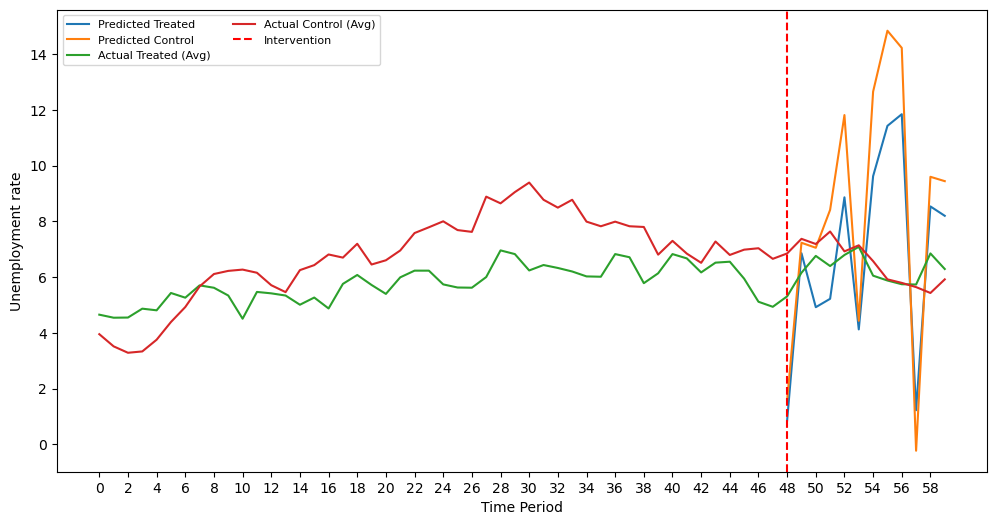

Treated Group - Mean: 103.05649734274634 Median: 37.2708164772505
Control Group - Mean: -152.70378370729355 Median: 42.42405485652086
Shapiro-Wilk test p-value for Treated Group: 7.416566222673282e-05
Shapiro-Wilk test p-value for Control Group: 4.449874268175336e-06
Wilcoxon test p-value: 0.7333984375
 
sim_10_222_l_ho
True Average Treatement Effect for q > 90%: :  3.2725601371738193
Average Treatment Effect for q > 90%:  8.059755652951436
Relative Difference for TTE : 1.4628288908731362


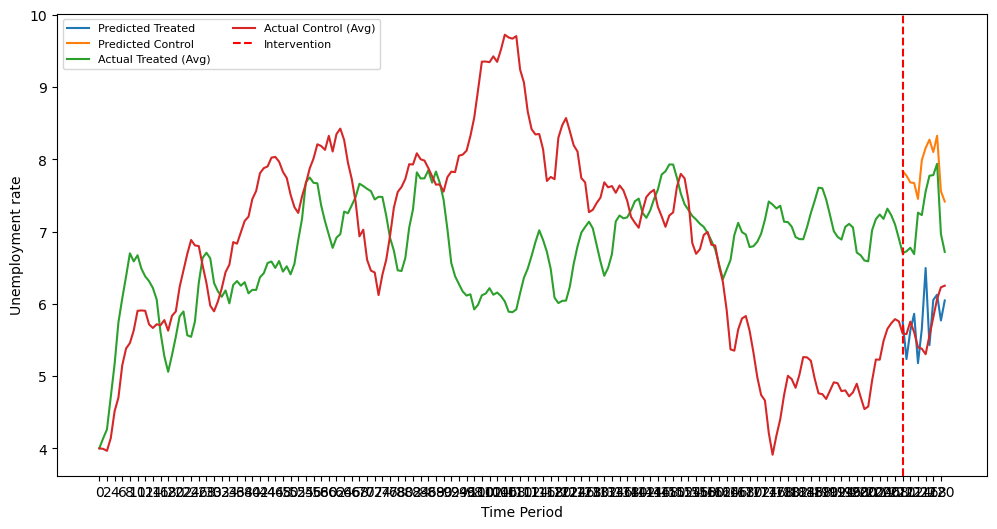

Treated Group - Mean: 24.747011603009792 Median: 24.33166045543476
Control Group - Mean: 27.12557588250674 Median: 27.868978862739933
Shapiro-Wilk test p-value for Treated Group: 0.39565202593803406
Shapiro-Wilk test p-value for Control Group: 0.12362803518772125
T-Test p-value: 0.3934085746610664
 
sim_10_222_nl_ho
True Average Treatement Effect for q > 90%: :  2.519109237139144
Average Treatment Effect for q > 90%:  6.281327360466099
Relative Difference for TTE : 1.493471608083007


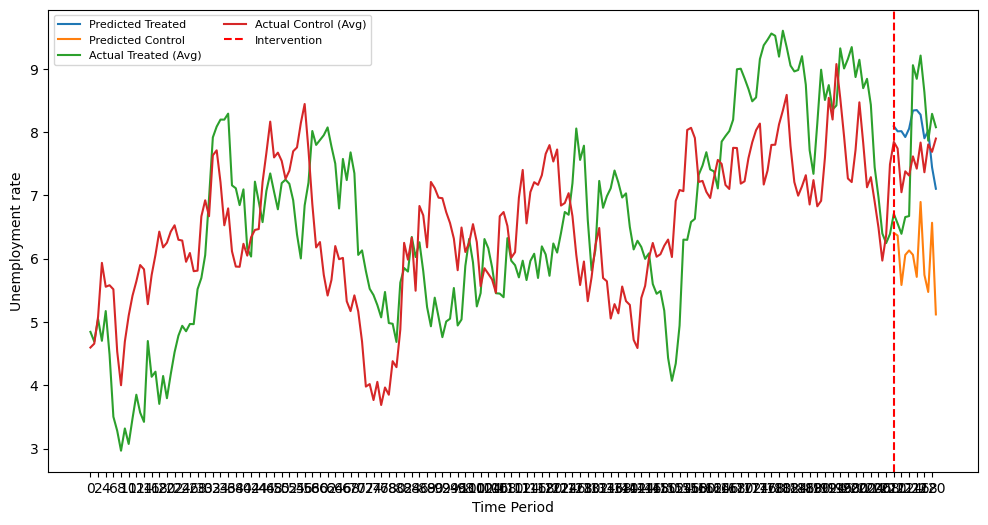

Treated Group - Mean: 12.553429778004338 Median: 12.521436561177303
Control Group - Mean: 26.892354041620948 Median: 24.064461853529107
Shapiro-Wilk test p-value for Treated Group: 0.7934087514877319
Shapiro-Wilk test p-value for Control Group: 0.04484603926539421
Wilcoxon test p-value: 0.00048828125
 
sim_101_60_l_ho
True Average Treatement Effect for q > 90%: :  1.7810526799236115
Average Treatment Effect for q > 90%:  6.171099695821988
Relative Difference for TTE : 2.464860846275846


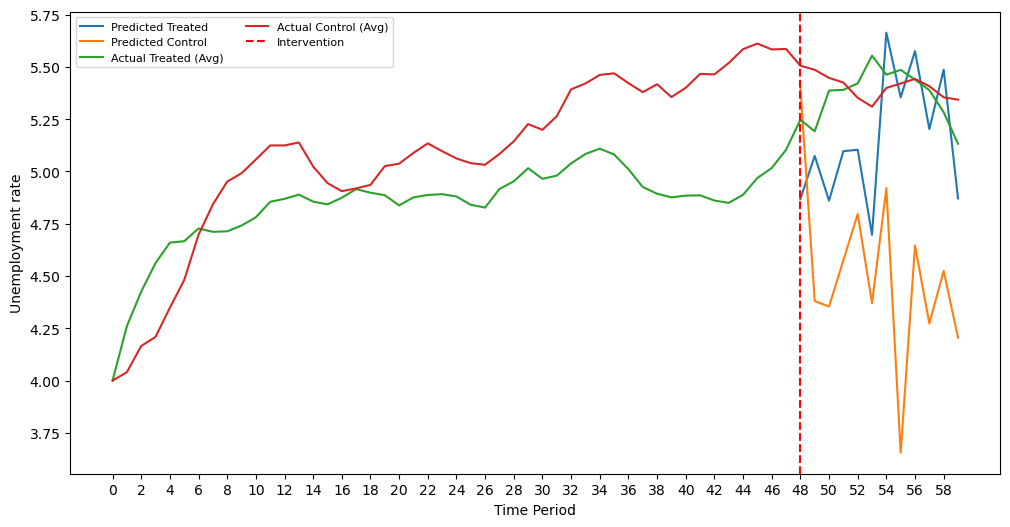

Treated Group - Mean: 6.020206702753202 Median: 4.541006169705277
Control Group - Mean: 20.925495169901478 Median: 20.045646699940797
Shapiro-Wilk test p-value for Treated Group: 0.004931691102683544
Shapiro-Wilk test p-value for Control Group: 0.3187803030014038
Wilcoxon test p-value: 0.00244140625
 
sim_101_60_nl_ho
True Average Treatement Effect for q > 90%: :  2.478116364052795
Average Treatment Effect for q > 90%:  5.109940177422731
Relative Difference for TTE : 1.0620259207948421


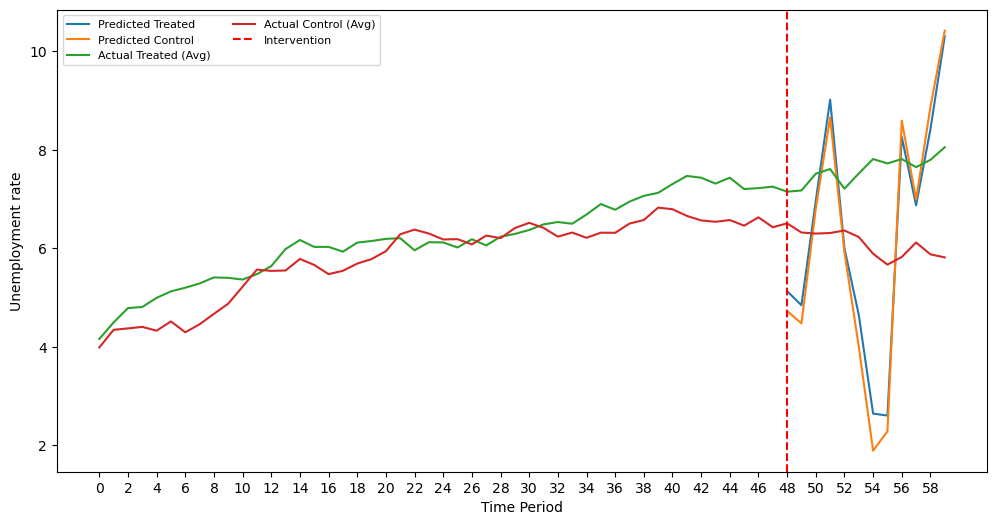

Treated Group - Mean: 52.554397179691854 Median: 21.017398902527706
Control Group - Mean: 54.87296859838823 Median: 35.68282768655108
Shapiro-Wilk test p-value for Treated Group: 0.00043581330101005733
Shapiro-Wilk test p-value for Control Group: 0.0010387037182226777
Wilcoxon test p-value: 0.6220703125
 
sim_101_222_l_ho
True Average Treatement Effect for q > 90%: :  2.4447549587392814
Average Treatment Effect for q > 90%:  6.651886257110343
Relative Difference for TTE : 1.7208805665090492


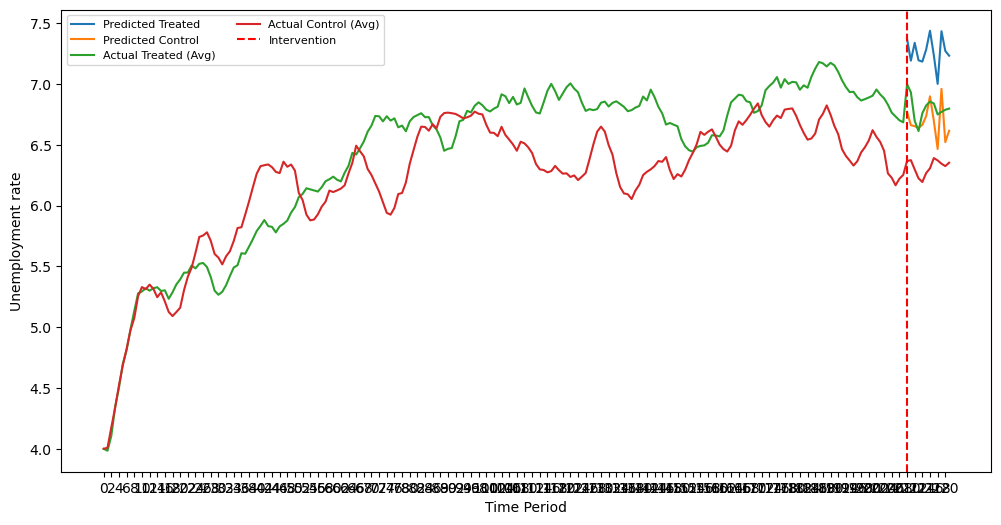

Treated Group - Mean: 6.351748949489722 Median: 6.168542245815161
Control Group - Mean: 5.528284411973371 Median: 5.654385219797886
Shapiro-Wilk test p-value for Treated Group: 0.5448881387710571
Shapiro-Wilk test p-value for Control Group: 0.9782487750053406
T-Test p-value: 0.12855736464815895
 
sim_101_222_nl_ho
True Average Treatement Effect for q > 90%: :  3.0113475399169864
Average Treatment Effect for q > 90%:  6.473043543779998
Relative Difference for TTE : 1.149550477975863


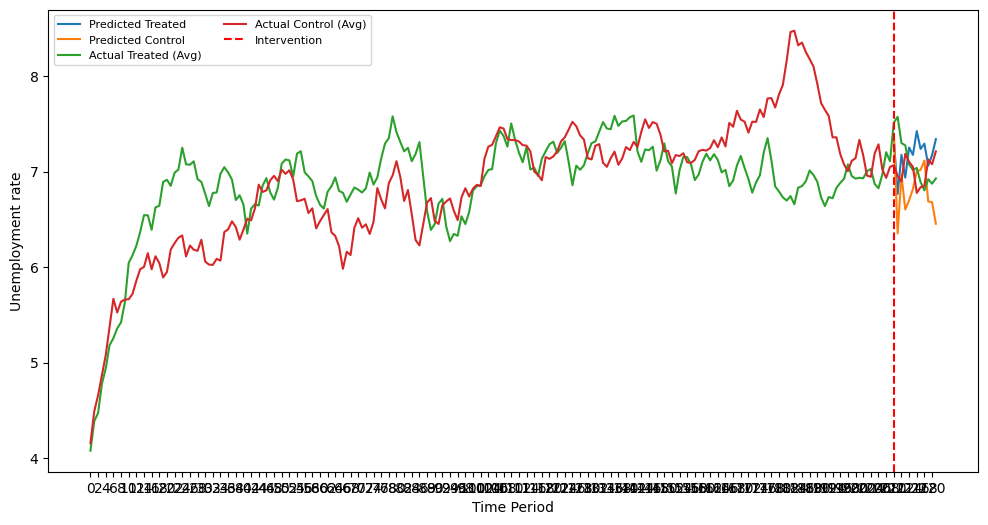

Treated Group - Mean: 4.480796887281961 Median: 4.482099654856647
Control Group - Mean: 5.577859746672906 Median: 5.180393744538735
Shapiro-Wilk test p-value for Treated Group: 0.019522780552506447
Shapiro-Wilk test p-value for Control Group: 0.7101527452468872
Wilcoxon test p-value: 0.30126953125
 
sim_500_60_l_ho
True Average Treatement Effect for q > 90%: :  2.06178214269649
Average Treatment Effect for q > 90%:  4.894326418661059
Relative Difference for TTE : 1.3738329658147304


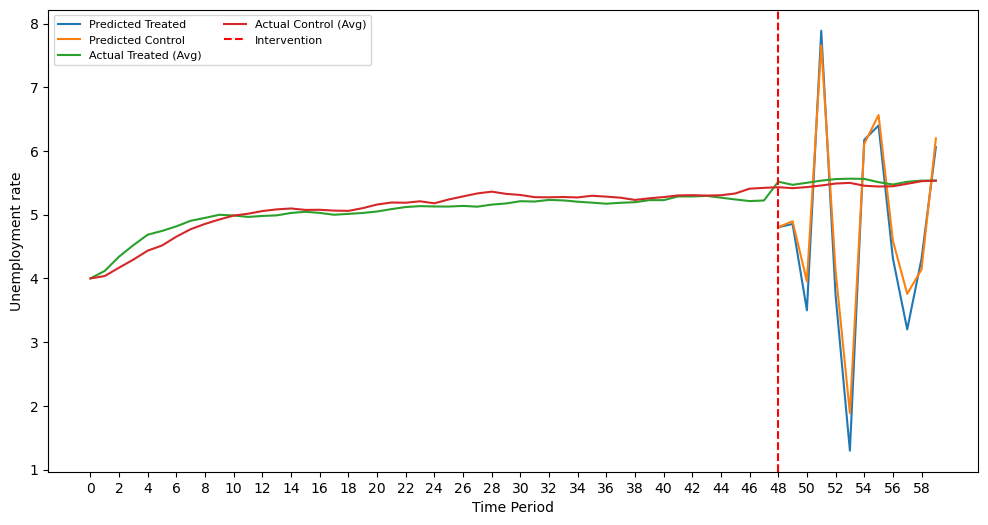

Treated Group - Mean: 54.4176019290713 Median: 27.622682296916594
Control Group - Mean: 37.62019461413372 Median: 23.663223511723547
Shapiro-Wilk test p-value for Treated Group: 2.7145568310515955e-05
Shapiro-Wilk test p-value for Control Group: 3.709475276991725e-05
Wilcoxon test p-value: 0.12939453125
 
sim_500_60_nl_ho
True Average Treatement Effect for q > 90%: :  2.484662259825148
Average Treatment Effect for q > 90%:  7.06511862291268
Relative Difference for TTE : 1.8434925491281335


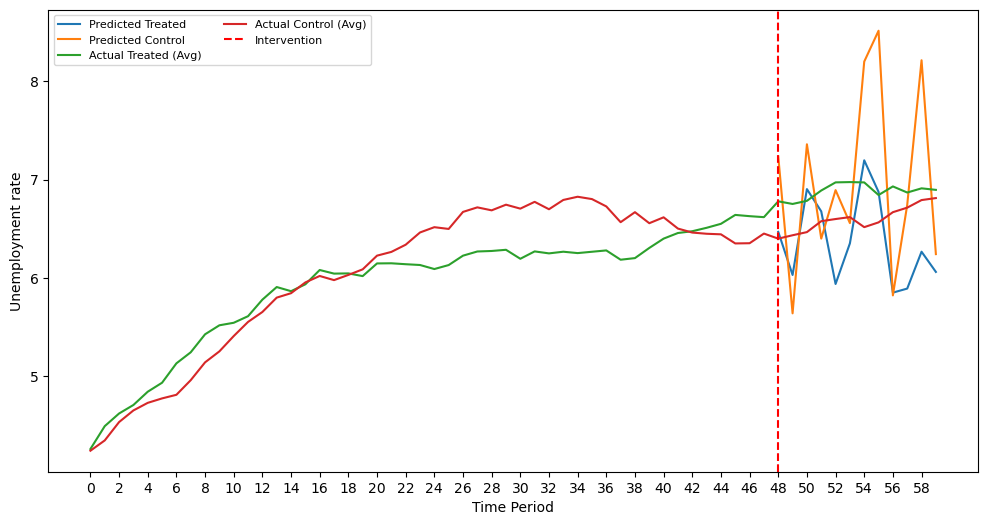

Treated Group - Mean: 9.295116147823252 Median: 10.045760012232016
Control Group - Mean: 10.877514217066777 Median: 11.843811376734827
Shapiro-Wilk test p-value for Treated Group: 0.25797733664512634
Shapiro-Wilk test p-value for Control Group: 0.594768226146698
T-Test p-value: 0.6514977903782098
 
sim_500_222_l_ho
True Average Treatement Effect for q > 90%: :  2.496153724416221
Average Treatment Effect for q > 90%:  7.80662648792439
Relative Difference for TTE : 2.1274622278121664


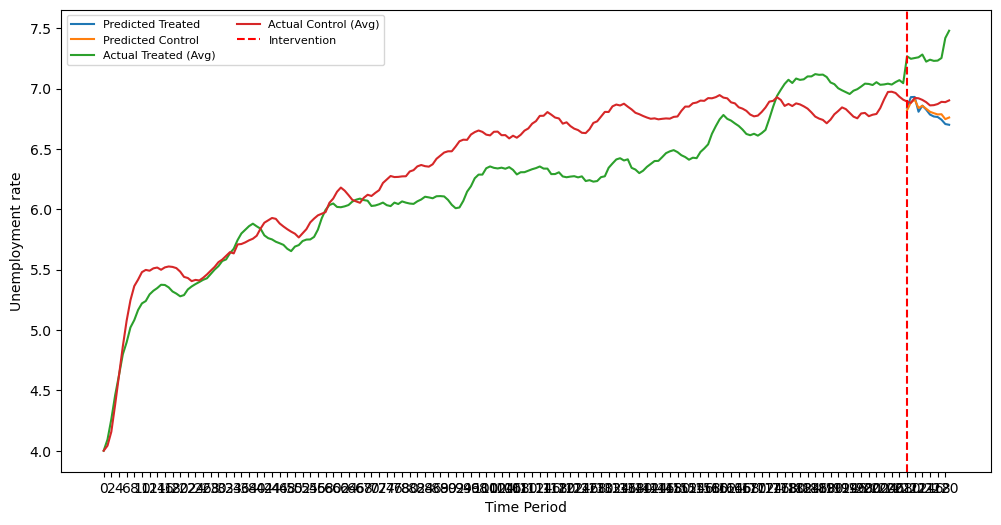

Treated Group - Mean: 7.0270025905041855 Median: 6.66405913066548
Control Group - Mean: 1.0599988286363262 Median: 1.0202725350639508
Shapiro-Wilk test p-value for Treated Group: 0.02759721502661705
Shapiro-Wilk test p-value for Control Group: 0.6401941776275635
Wilcoxon test p-value: 0.00048828125
 
sim_500_222_nl_ho
True Average Treatement Effect for q > 90%: :  2.650445194073532
Average Treatment Effect for q > 90%:  7.598711156932269
Relative Difference for TTE : 1.8669565301418778


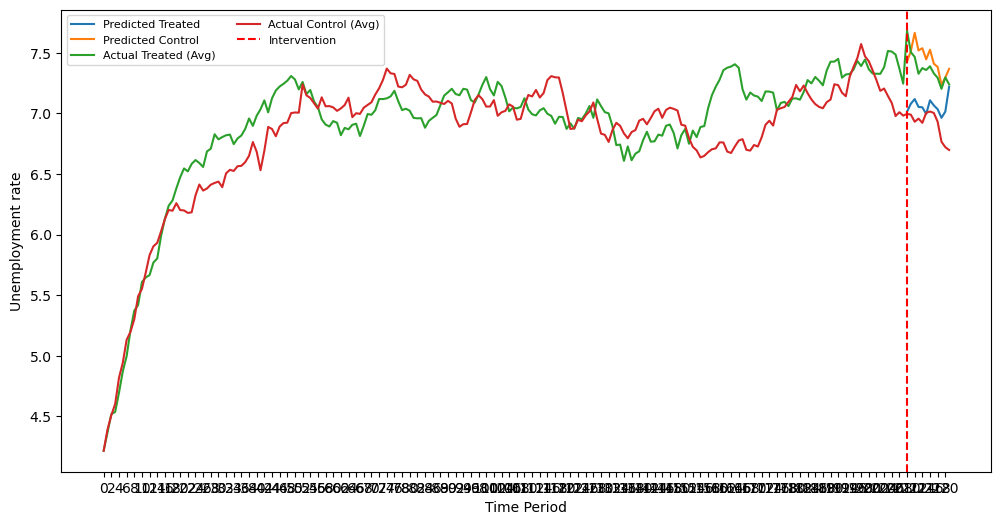

Treated Group - Mean: 4.430836492123579 Median: 3.990798589355294
Control Group - Mean: 7.149386037563502 Median: 6.884166118787801
Shapiro-Wilk test p-value for Treated Group: 0.05489683523774147
Shapiro-Wilk test p-value for Control Group: 0.5171895027160645
T-Test p-value: 0.007998178337721991
 
sim_10_60_l_he
True Average Treatement Effect for q > 90%: :  7.516165720896714
Average Treatment Effect for q > 90%:  1.3169443610310658
Relative Difference for TTE : -0.8247850819241984


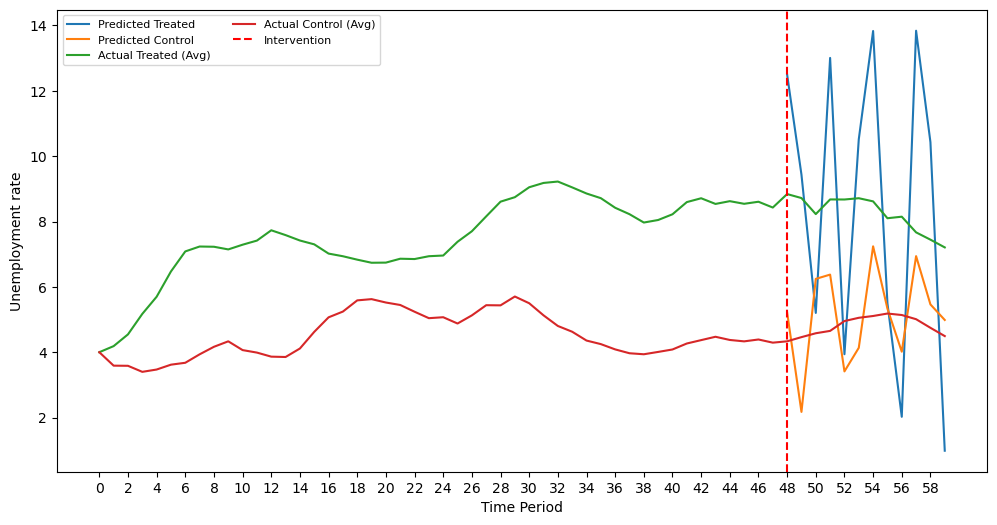

Treated Group - Mean: 113.18198042612418 Median: 41.146861253051426
Control Group - Mean: 29.52815693589328 Median: 26.833990876917213
Shapiro-Wilk test p-value for Treated Group: 9.340472752228379e-05
Shapiro-Wilk test p-value for Control Group: 0.0013461032649502158
Wilcoxon test p-value: 0.02685546875
 
sim_10_60_nl_he
True Average Treatement Effect for q > 90%: :  5.903977741996105
Average Treatment Effect for q > 90%:  6.811678421185402
Relative Difference for TTE : 0.1537439195836819


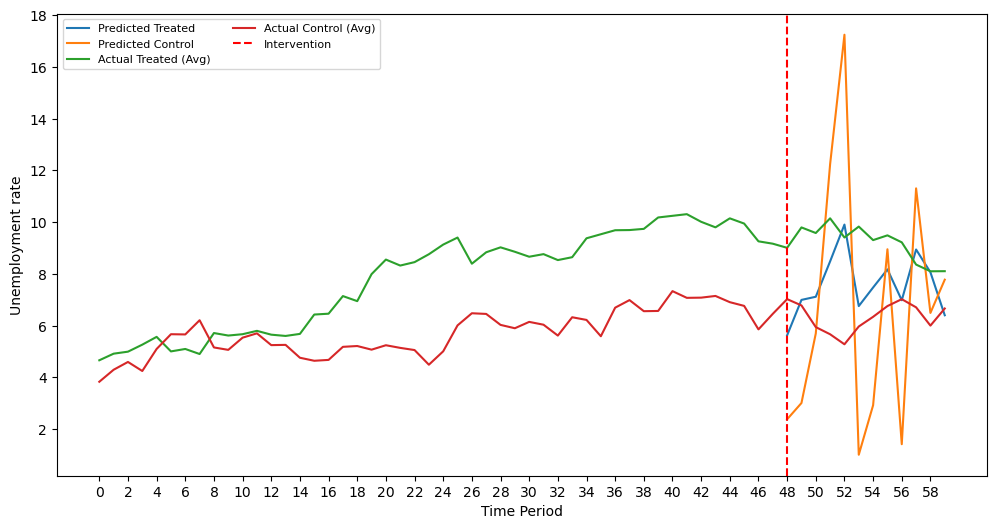

Treated Group - Mean: 25.910125713328146 Median: 25.53900453285953
Control Group - Mean: 127.7918678955449 Median: 61.529669036336756
Shapiro-Wilk test p-value for Treated Group: 0.9576798677444458
Shapiro-Wilk test p-value for Control Group: 0.0039902376011013985
Wilcoxon test p-value: 0.00927734375
 
sim_10_222_l_he
True Average Treatement Effect for q > 90%: :  3.0618895976869673
Average Treatment Effect for q > 90%:  6.8120411144645825
Relative Difference for TTE : 1.2247833885358177


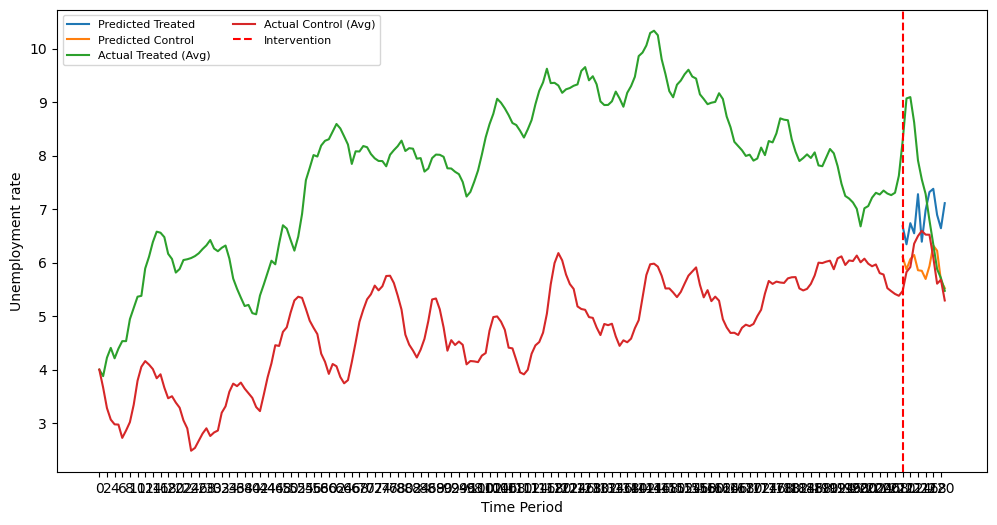

Treated Group - Mean: 19.810357986202344 Median: 16.458912326775092
Control Group - Mean: 6.922232216445978 Median: 7.0357172561655315
Shapiro-Wilk test p-value for Treated Group: 0.5652190446853638
Shapiro-Wilk test p-value for Control Group: 0.17465049028396606
T-Test p-value: 0.015041927700130771
 
sim_10_222_nl_he
True Average Treatement Effect for q > 90%: :  0.2467764798832448
Average Treatment Effect for q > 90%:  2.9121635832102015
Relative Difference for TTE : 10.800814990910025


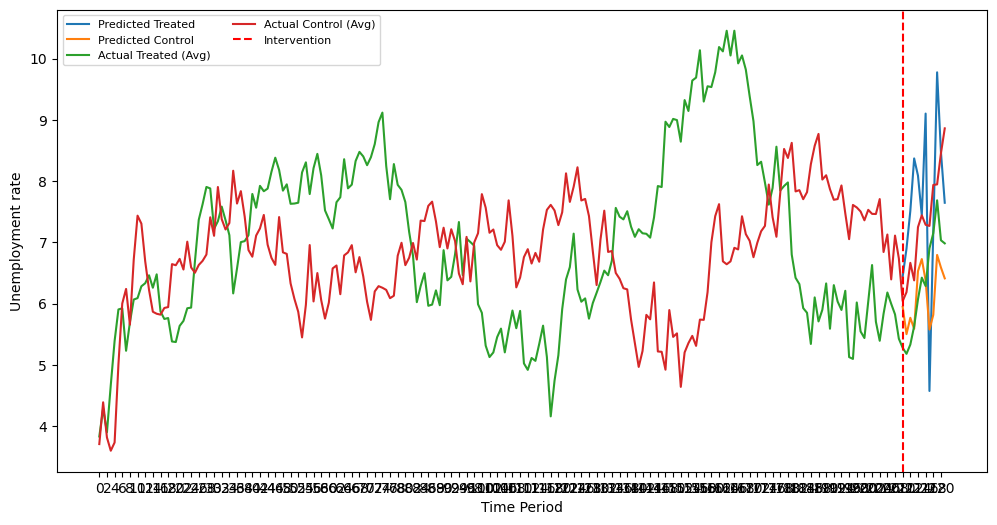

Treated Group - Mean: 22.714815335829716 Median: 23.12771124551578
Control Group - Mean: 19.140491651656973 Median: 14.891791007517249
Shapiro-Wilk test p-value for Treated Group: 0.9329028725624084
Shapiro-Wilk test p-value for Control Group: 0.18557871878147125
T-Test p-value: 0.5302607245228752
 
sim_101_60_l_he
True Average Treatement Effect for q > 90%: :  2.8430448836033904
Average Treatment Effect for q > 90%:  4.2368971327566705
Relative Difference for TTE : 0.49026740914011013


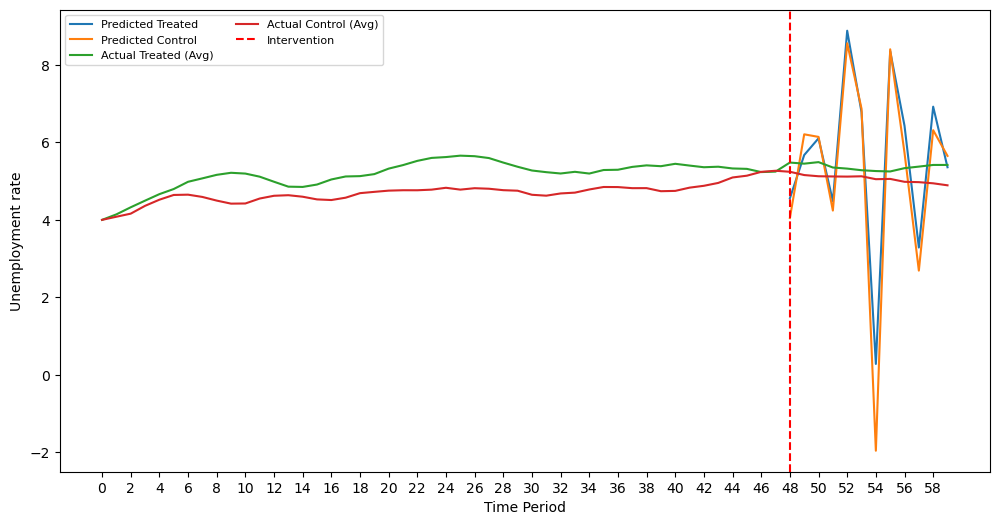

Treated Group - Mean: 168.4021419971467 Median: 20.99951292909303
Control Group - Mean: -2.985360409095654 Median: 21.2308993597534
Shapiro-Wilk test p-value for Treated Group: 1.8441394331603078e-06
Shapiro-Wilk test p-value for Control Group: 1.2364341273496393e-05
Wilcoxon test p-value: 0.12939453125
 
sim_101_60_nl_he
True Average Treatement Effect for q > 90%: :  3.1081858508084768
Average Treatment Effect for q > 90%:  6.202068075403904
Relative Difference for TTE : 0.9953980788473994


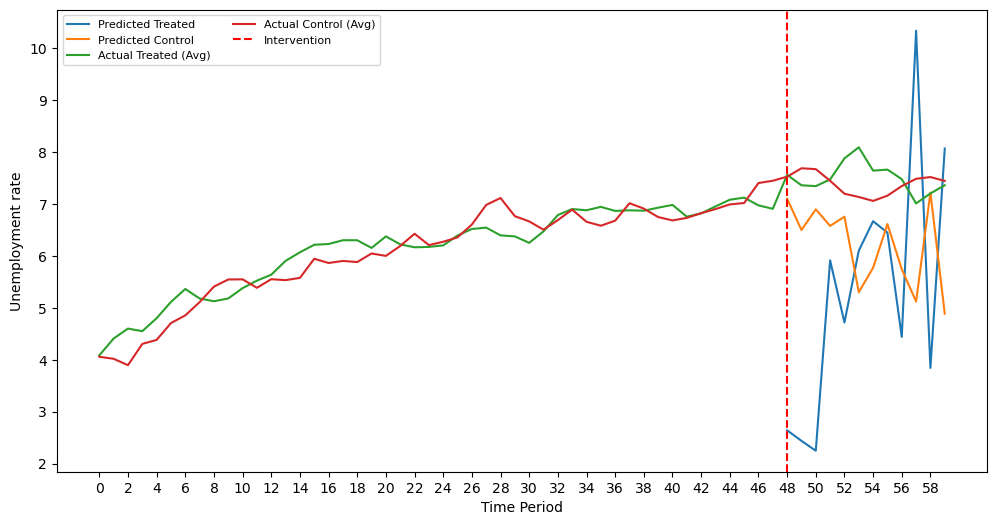

Treated Group - Mean: 80.86673653531453 Median: 49.791189440909086
Control Group - Mean: 20.896602506921763 Median: 15.742862936965814
Shapiro-Wilk test p-value for Treated Group: 0.010889261960983276
Shapiro-Wilk test p-value for Control Group: 0.10356448590755463
Wilcoxon test p-value: 0.06396484375
 
sim_101_222_l_he
True Average Treatement Effect for q > 90%: :  4.06578861338984
Average Treatment Effect for q > 90%:  8.758060087251096
Relative Difference for TTE : 1.1540864319429258


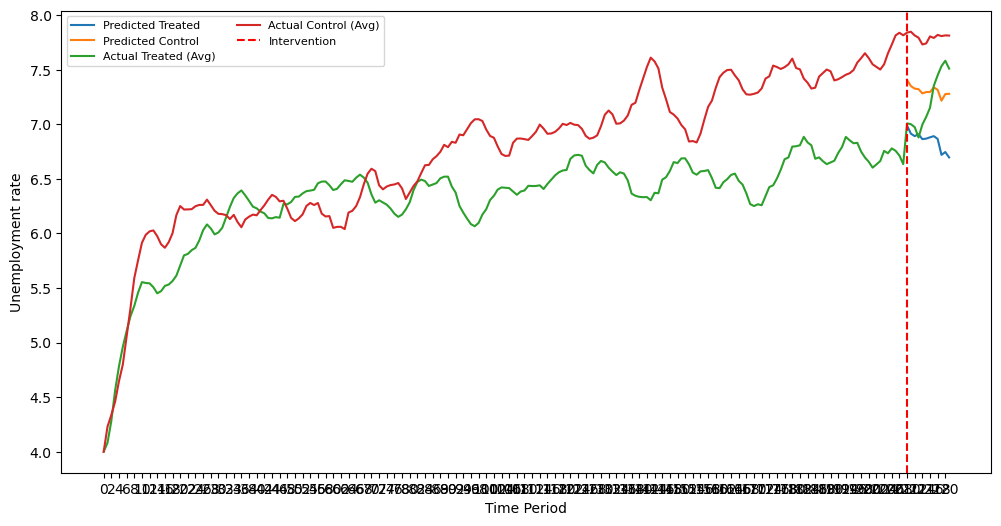

Treated Group - Mean: 5.316497585084634 Median: 3.4166823531771295
Control Group - Mean: 6.74413244315942 Median: 6.7128510413855285
Shapiro-Wilk test p-value for Treated Group: 0.0295967236161232
Shapiro-Wilk test p-value for Control Group: 0.5858076214790344
Wilcoxon test p-value: 0.2333984375
 
sim_101_222_nl_he
True Average Treatement Effect for q > 90%: :  3.3324278424214118
Average Treatment Effect for q > 90%:  7.153387445107953
Relative Difference for TTE : 1.146599351393653


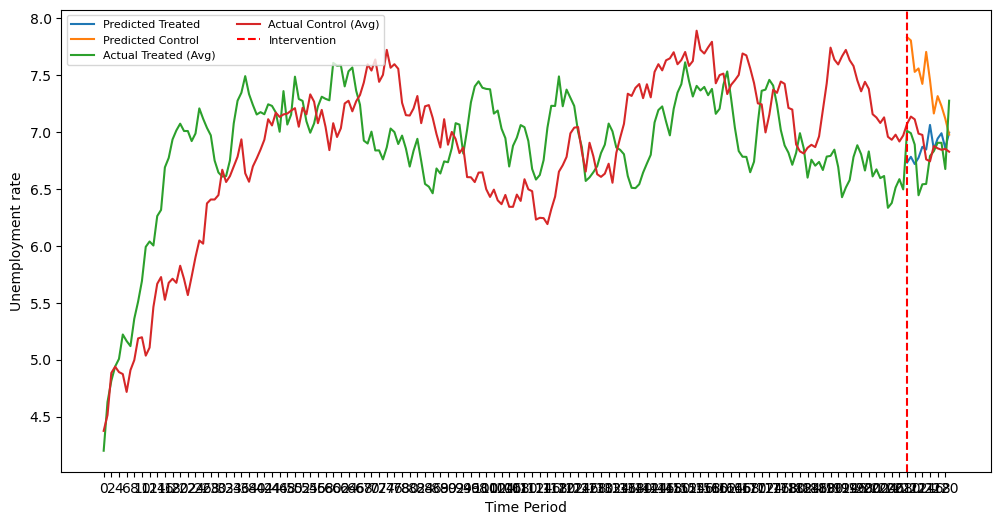

Treated Group - Mean: 3.0301761990412857 Median: 3.461851783819167
Control Group - Mean: 6.727254547935087 Median: 6.153950031295858
Shapiro-Wilk test p-value for Treated Group: 0.14832603931427002
Shapiro-Wilk test p-value for Control Group: 0.970294713973999
T-Test p-value: 0.0005354753381330926
 
sim_500_60_l_he
True Average Treatement Effect for q > 90%: :  2.6856358347513787
Average Treatment Effect for q > 90%:  3.995935842269949
Relative Difference for TTE : 0.4878919139235684


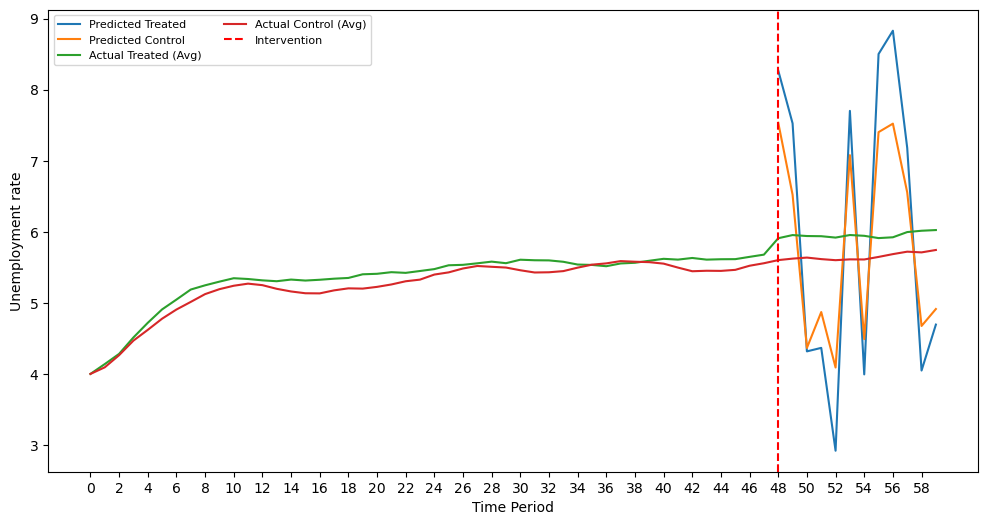

Treated Group - Mean: 37.84207545354929 Median: 31.695245450788292
Control Group - Mean: 22.199502833669367 Median: 22.935603498402575
Shapiro-Wilk test p-value for Treated Group: 0.0020907327998429537
Shapiro-Wilk test p-value for Control Group: 0.6496129035949707
Wilcoxon test p-value: 0.00048828125
 
sim_500_60_nl_he
True Average Treatement Effect for q > 90%: :  3.823639816723576
Average Treatment Effect for q > 90%:  7.358077034917706
Relative Difference for TTE : 0.9243645812912212


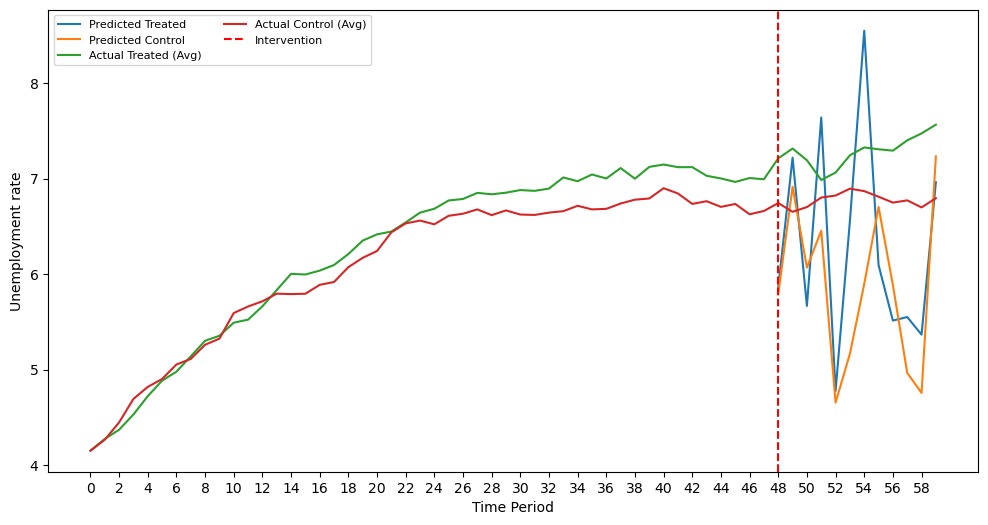

Treated Group - Mean: 22.17324780394905 Median: 21.468763718659368
Control Group - Mean: 19.35172578095683 Median: 15.542747033302945
Shapiro-Wilk test p-value for Treated Group: 0.8712050318717957
Shapiro-Wilk test p-value for Control Group: 0.09557616710662842
T-Test p-value: 0.41044826435654647
 
sim_500_222_l_he
True Average Treatement Effect for q > 90%: :  3.454186759598919
Average Treatment Effect for q > 90%:  9.098961906413088
Relative Difference for TTE : 1.6341835400554916


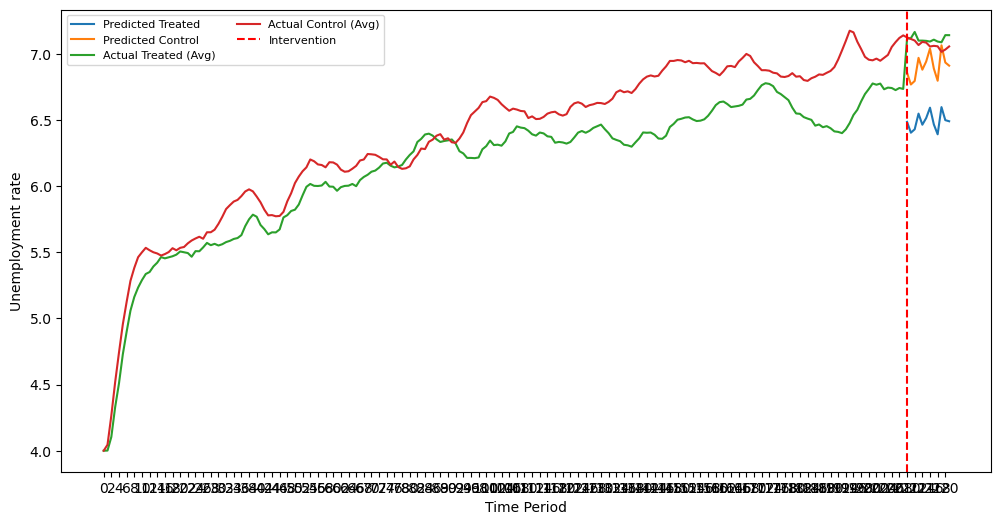

Treated Group - Mean: 9.61303278111424 Median: 9.86471762712435
Control Group - Mean: 2.56073321362858 Median: 2.2942376711234553
Shapiro-Wilk test p-value for Treated Group: 0.39920398592948914
Shapiro-Wilk test p-value for Control Group: 0.8766828775405884
T-Test p-value: 1.8223745384781736e-12
 
sim_500_222_nl_he
True Average Treatement Effect for q > 90%: :  1.8484827643495443
Average Treatment Effect for q > 90%:  6.818811867548281
Relative Difference for TTE : 2.6888695956803943


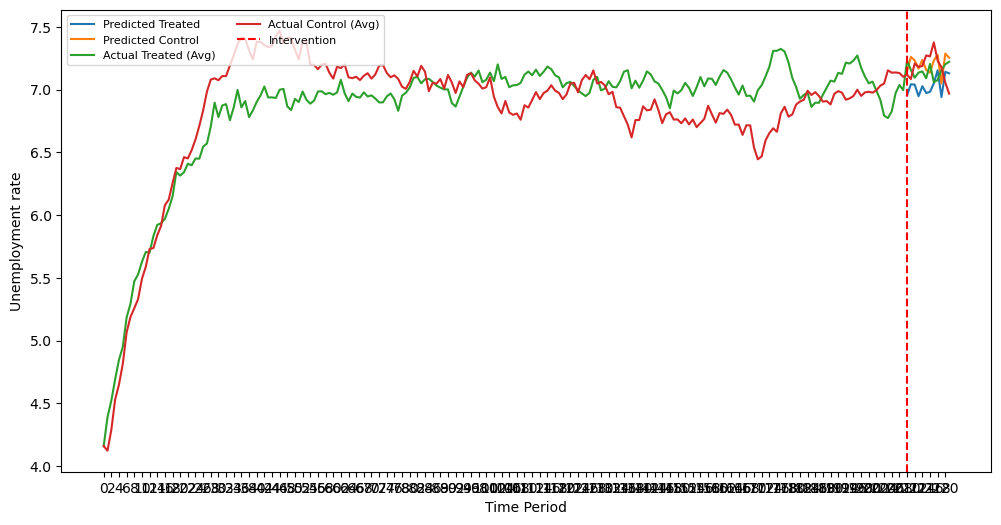

Treated Group - Mean: 1.8413051309276947 Median: 1.6484715547491913
Control Group - Mean: 1.5850854328616748 Median: 1.7194079378960834
Shapiro-Wilk test p-value for Treated Group: 0.5613037347793579
Shapiro-Wilk test p-value for Control Group: 0.2959303557872772
T-Test p-value: 0.65028420096903
 


In [135]:
dataset_name_test = ['calls911_benchmarks',\
                     'sim_10_60_l_ho','sim_10_60_nl_ho',\
                     'sim_10_222_l_ho','sim_10_222_nl_ho',\
                     'sim_101_60_l_ho', 'sim_101_60_nl_ho',\
                     'sim_101_222_l_ho', 'sim_101_222_nl_ho',\
                     'sim_500_60_l_ho', 'sim_500_60_nl_ho',\
                     'sim_500_222_l_ho', 'sim_500_222_nl_ho',\
                     'sim_10_60_l_he', 'sim_10_60_nl_he',\
                     'sim_10_222_l_he', 'sim_10_222_nl_he',\
                     'sim_101_60_l_he', 'sim_101_60_nl_he',\
                     'sim_101_222_l_he', 'sim_101_222_nl_he',\
                     'sim_500_60_l_he', 'sim_500_60_nl_he',\
                     'sim_500_222_l_he', 'sim_500_222_nl_he']
data_type = ['calls911'] + ['sim']*24
te = [None] + ['homogeneous']*12 + ['heterogeneous']*12
model = 'tsmixer'
for i in range(len(dataset_name_test)):
    print(dataset_name_test[i])
    table2(dataset_name_test[i], data_type[i], model, te[i], plot_or_not=True)
    print(" ")

In [30]:
dataset_name_test = ['calls911_benchmarks',\
                     'sim_10_60_l_ho','sim_10_60_nl_ho',\
                     'sim_10_222_l_ho','sim_10_222_nl_ho',\
                     'sim_101_60_l_ho', 'sim_101_60_nl_ho',\
                     'sim_101_222_l_ho', 'sim_101_222_nl_ho',\
                     'sim_500_60_l_ho', 'sim_500_60_nl_ho',\
                     'sim_500_222_l_ho', 'sim_500_222_nl_ho',\
                     'sim_10_60_l_he', 'sim_10_60_nl_he',\
                     'sim_10_222_l_he', 'sim_10_222_nl_he',\
                     'sim_101_60_l_he', 'sim_101_60_nl_he',\
                     'sim_101_222_l_he', 'sim_101_222_nl_he',\
                     'sim_500_60_l_he', 'sim_500_60_nl_he',\
                     'sim_500_222_l_he', 'sim_500_222_nl_he']
data_type = ['calls911'] + ['sim']*24
te = [None] + ['homogeneous']*12 + ['heterogeneous']*12
model = 'tft'
for i in range(len(dataset_name_test)):
    print(dataset_name_test[i])
    table2(dataset_name_test[i], data_type[i], model, te[i], plot_or_not=True)
    print(" ")

calls911_benchmarks
(7, 62)


TypeError: bad operand type for unary -: 'NoneType'

In [280]:
def plot_ts2(dataset_name, quantiles, plot=False):
    data_train = pd.read_csv('./datasets/text_data/sim/'+dataset_name+'_train.csv')
    data_test = pd.read_csv('./datasets/text_data/sim/'+dataset_name+'_test_actual.csv')
    data_index = pd.concat([data_train,data_test],axis=0)
    # data_index = data_index.sort_values(by=['series_id','time'], ignore_index=True)
    data_index['tnc'] = ['1' if i == 'treated' else '0' for i in data_index['c_t']]
    data_index.set_index(data_index['time'], inplace=True)
    data_full = data_index.drop(['time'], axis=1)
    
    predicted_csv_files = {q: './results/nn_model_results/rnn/processed_ensemble_forecasts/'+dataset_name+'_LSTMcell_cocob_without_stl_decomposition_'+f'{q}.txt' for q in quantiles}
    
    # Create a dictionary to store the dataframes for each quantile
    dfs = {q: [] for q in quantiles}

    # Iterate over each quantile
    for quantile, files in predicted_csv_files.items():
        # Iterate over each file for the quantile
        # Load the text data from CSV
        data = pd.read_csv(files, header=None)

        # Transpose the data for better visualization (units as rows, time periods as columns)
        transposed_data = data.transpose()

        # Append the transposed dataframe to the list for the current quantile
        dfs[quantile].append(transposed_data)

    # Concatenate the dataframes along the columns (units) for each quantile
    concatenated_data = {q: pd.concat(frames, axis=1) for q, frames in dfs.items()}
    diff_I_vec_all, diff_NI_vec_all = 0, 0
    for i in range(int(len(transposed_data.columns)/2)):
        # predicted treated units
        predicted_treated = {q: concatenated_data[q].iloc[:,\
                         int(i+len(transposed_data.columns)/2)]\
                              for q in quantiles}

        # actual treated units
        actual_treated = data_full[['_'+str(int(1+i+len(transposed_data.columns)/2))+\
                                    '_' in j for j in data_full.series_id]]
        actual_treated = actual_treated.pivot(columns=\
                                    'series_id')['value']

        # predicted control units
        predicted_control = {q: concatenated_data[q].iloc[\
                :,i] for q in quantiles}

        # actual control units
        actual_control = data_full[['_'+str(1+i)+\
                                    '_' in j for j in data_full.series_id]]
        actual_control = actual_control.pivot(columns=\
                                    'series_id')['value']
        if plot:
            # Plot the averages
            fig, ax = plt.subplots(figsize=(12, 6))

            for quantile, data in predicted_treated.items():
                ax.plot((len(actual_treated)-data.index-1)[::-1],\
                        data, label=f'Quantile {quantile} (Avg Treated Unit {i})')
            ax.plot(actual_treated.index, actual_treated,\
                    label=f'Actual (Avg Treated Unit {i})')

            for quantile, data in predicted_control.items():
                ax.plot((len(actual_treated)-data.index-1)[::-1],\
                        data, label=f'Quantile {quantile} (Avg Control Unit {i})')
            ax.plot(actual_control.index, actual_control,\
                    label=f'Actual (Avg Control Unit {i})')

            
            # Add a vertical line at 2020-01
            plt.axvline(len(actual_control)-12, color='red', linestyle='--', label='Intervention')

            ax.set_xlabel('Time Period')
            ax.set_ylabel(str(dataset_name))
            ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=8)
            plt.xticks(actual_control.index[::2])
            plt.show()

        # MEAN DIFFERENCE TESTING

        # 1. Preparing the data

        # Treated group
        diff_I = pd.DataFrame({'Predicted':predicted_treated['0.5']})
        diff_I['Y'] = actual_treated.iloc[-len(predicted_treated["0.5"]):,0].values
        diff_I['ab_diff'] = abs(diff_I['Predicted'] - diff_I['Y'])
        diff_I['ab_sum_av'] = (abs(diff_I['Predicted']) + abs(diff_I['Y'])) / 2
        diff_I['ab_diff_propY'] = diff_I['ab_diff'] / diff_I['Y']
        diff_I['ab_diff_propT'] = diff_I['ab_diff'] / diff_I['Predicted']
        diff_I['ab_diff_propYF'] = diff_I['ab_diff'] / diff_I['ab_sum_av']

        # Control group
        diff_NI = pd.DataFrame({'Predicted':predicted_control['0.5']})
        diff_NI['Y'] = actual_control.iloc[-len(predicted_control["0.5"]):,0].values
        diff_NI['ab_diff'] = abs(diff_NI['Predicted'] - diff_NI['Y'])
        diff_NI['ab_sum_av'] = (abs(diff_NI['Predicted']) + abs(diff_NI['Y'])) / 2
        diff_NI['ab_diff_propY'] = diff_NI['ab_diff'] / diff_NI['Y']
        diff_NI['ab_diff_propT'] = diff_NI['ab_diff'] / diff_NI['Predicted']
        diff_NI['ab_diff_propYF'] = diff_NI['ab_diff'] / diff_NI['ab_sum_av']

        # 2. MEAN SIGNIFICANCE TESTS FOR relative differences
        diff_I_vec_i = diff_I['ab_diff_propT'].values * 100
        diff_NI_vec_i = diff_NI['ab_diff_propT'].values * 100

        # print(i, int(i+len(transposed_data.columns)/2))
        # # Display mean and median for each group
        # print("Treated Group - Mean:", diff_I_vec_i.mean(), "Median:", pd.Series(diff_I_vec_i).median())
        # print("Control Group - Mean:", diff_NI_vec_i.mean(), "Median:", pd.Series(diff_NI_vec_i).median())

        diff_I_vec_all += diff_I_vec_i
        diff_NI_vec_all += diff_NI_vec_i

    diff_I_vec = diff_I_vec_all/int(len(transposed_data.columns)/2)
    diff_NI_vec = diff_NI_vec_all/int(len(transposed_data.columns)/2)
    # Display mean and median for each group
    print("Treated Group - Mean:", diff_I_vec.mean(), "Median:", pd.Series(diff_I_vec).median())
    print("Control Group - Mean:", diff_NI_vec.mean(), "Median:", pd.Series(diff_NI_vec).median())

    # Shapiro-Wilk’s test for normality
    shapiro_diff_I = shapiro(diff_I_vec)
    shapiro_diff_NI = shapiro(diff_NI_vec)

    print("Shapiro-Wilk test p-value for Treated Group:", shapiro_diff_I.pvalue)
    print("Shapiro-Wilk test p-value for Control Group:", shapiro_diff_NI.pvalue)

    # Apply t-test if data is normally distributed, otherwise Wilcoxon signed-rank test
    if shapiro_diff_I.pvalue > 0.05 and shapiro_diff_NI.pvalue > 0.05:
        t_test_result = ttest_rel(diff_I_vec, diff_NI_vec)
        print("T-Test p-value:", t_test_result.pvalue)
    else:
        wilcoxon_test_result = wilcoxon(diff_I_vec, diff_NI_vec)
        print("Wilcoxon test p-value:", wilcoxon_test_result.pvalue)

In [290]:
dataset_name_test = ['sim_10_60_l_he', 'sim_10_60_l_ho',\
                     'sim_10_60_nl_he', 'sim_10_60_nl_ho',\
                     'sim_10_222_l_he', 'sim_10_222_l_ho',\
                     'sim_10_222_nl_he', 'sim_10_222_nl_ho',\
                     'sim_101_60_l_he', 'sim_101_60_l_ho',\
                     'sim_101_60_nl_he', 'sim_101_60_nl_ho',\
                     'sim_101_222_l_he', 'sim_101_222_l_ho',\
                     'sim_101_222_nl_he', 'sim_101_222_nl_ho',\
                     'sim_500_60_l_he', 'sim_500_60_l_ho',\
                     'sim_500_60_nl_he', 'sim_500_60_nl_ho',\
                     'sim_500_222_l_he', 'sim_500_222_l_ho',\
                     'sim_500_222_nl_he', 'sim_500_222_nl_ho']
for i in dataset_name_test:
    print(i)
    plot_ts2(i, quantiles)
    print(" ")

sim_10_60_l_he
Treated Group - Mean: 15.618215236269316 Median: 15.899502866452757
Control Group - Mean: 29.12917456648903 Median: 25.585543726295175
Shapiro-Wilk test p-value for Treated Group: 0.14155853378382338
Shapiro-Wilk test p-value for Control Group: 0.007962737339305746
Wilcoxon test p-value: 0.0068359375
 
sim_10_60_l_ho
Treated Group - Mean: 20.323539195375744 Median: 20.861970753176642
Control Group - Mean: 15.646872157562195 Median: 15.627142579049405
Shapiro-Wilk test p-value for Treated Group: 0.22107268087287274
Shapiro-Wilk test p-value for Control Group: 0.9199643391541742
T-Test p-value: 0.005536300102258698
 
sim_10_60_nl_he
Treated Group - Mean: 30.24539490028562 Median: 34.74146921048741
Control Group - Mean: 35.48195444074369 Median: 36.53364103284851
Shapiro-Wilk test p-value for Treated Group: 0.07377012825313885
Shapiro-Wilk test p-value for Control Group: 0.3041553763695413
T-Test p-value: 0.06122230336017505
 
sim_10_60_nl_ho
Treated Group - Mean: 38.150497

In [282]:
dataset_name = ''

plot_ts2(dataset_name, quantiles)

Treated Group - Mean: 20.323539195375744 Median: 20.861970753176642
Control Group - Mean: 15.646872157562195 Median: 15.627142579049405
Shapiro-Wilk test p-value for Treated Group: 0.22107268087287274
Shapiro-Wilk test p-value for Control Group: 0.9199643391541742
T-Test p-value: 0.005536300102258698


In [284]:
dataset_name = ''

plot_ts2(dataset_name, quantiles)

Treated Group - Mean: 30.24539490028562 Median: 34.74146921048741
Control Group - Mean: 35.48195444074369 Median: 36.53364103284851
Shapiro-Wilk test p-value for Treated Group: 0.07377012825313885
Shapiro-Wilk test p-value for Control Group: 0.3041553763695413
T-Test p-value: 0.06122230336017505


In [285]:
dataset_name = ''

plot_ts2(dataset_name, quantiles)

Treated Group - Mean: 38.150497276036994 Median: 40.10201255057345
Control Group - Mean: 37.096155381747955 Median: 38.60516960851412
Shapiro-Wilk test p-value for Treated Group: 0.11587994082224157
Shapiro-Wilk test p-value for Control Group: 0.5199990123338567
T-Test p-value: 0.8011664820798412


In [286]:
dataset_name = ''

plot_ts2(dataset_name, quantiles)

Treated Group - Mean: 20.815194799366747 Median: 21.40583616084313
Control Group - Mean: 21.71242806026271 Median: 21.04102333413226
Shapiro-Wilk test p-value for Treated Group: 0.5906986399592229
Shapiro-Wilk test p-value for Control Group: 0.9997779914706143
T-Test p-value: 0.7379919963783228


In [287]:
dataset_name = ''

plot_ts2(dataset_name, quantiles)

Treated Group - Mean: 21.993227808329888 Median: 21.81527513204629
Control Group - Mean: 70.15176436364546 Median: 66.64181729191866
Shapiro-Wilk test p-value for Treated Group: 0.6479539553505806
Shapiro-Wilk test p-value for Control Group: 0.06574801474918941
T-Test p-value: 0.0018825822836798108


In [190]:
for quantile, files in predicted_csv_files.items():
    # Iterate over each file for the quantile
    # Load the text data from CSV
    data = pd.read_csv(files, header=None)

    # Transpose the data for better visualization (units as rows, time periods as columns)
    transposed_data = data.transpose()

    # Append the transposed dataframe to the list for the current quantile
    dfs[quantile].append(transposed_data)

# Concatenate the dataframes along the columns (units) for each quantile
concatenated_data = {q: pd.concat(frames, axis=1) for q, frames in dfs.items()}

# # average predicted treated units
# averages_predicted_treated = {q: concatenated_data[q].iloc[\
#         :,int(len(concatenated_data[q].columns)/2):].mean(axis=1)\
#             for q in quantiles}

In [192]:
transposed_data

0         1         2         3         4          5         6  \
0   6.991125  6.301158  1.595579  4.514176  2.202325  10.145553  2.893547   
1   7.375317  6.254870  1.572927  5.039123  1.954142   9.927241  2.912477   
2   7.393527  6.176349  1.663244  5.125019  2.138897   9.569663  3.100625   
3   7.445085  6.170067  1.693623  5.148317  2.022850   9.543782  3.166734   
4   7.664696  6.187992  1.740414  5.297991  1.603850   9.578660  3.270230   
5   7.391281  6.169939  1.860753  4.889910  1.727492   9.499311  3.498094   
6   7.419874  6.200983  1.950261  4.669951  1.547841   9.502851  3.709254   
7   7.198283  6.163843  2.115844  4.126119  1.765592   9.431769  4.047940   
8   6.974879  6.237054  2.111642  3.937458  1.799502   9.581570  3.906496   
9   6.677223  6.250865  2.138978  3.792397  1.888351   9.691827  3.758876   
10  6.532202  6.369555  2.095741  3.621396  1.609434  10.089239  3.559546   
11  6.591457  6.467858  2.087447  3.701746  1.226491  10.348900  3.511258   

            7          8         9  
0   12.484855  10.268354  6.131543  
1   12.661434  10.317207  6.068119  
2   12.745415  10.405247  6.069724  
3   12.699887  10.411573  6.076473  
4   12.557126  10.404446  6.129312  
5   12.416968  10.431839  6.205075  
6   12.109759  10.419241  6.323229  
7   11.730433  10.492127  6.499066  
8   11.514966  10.271623  6.534376  
9   11.395530  10.090722  6.540368  
10  11.130563   9.864840  6.608108  
11  11.015445   9.701056  6.603352

In [193]:
'_'+str(int(1+i+len(transposed_data.columns)/2))+'_'

'_6_'

In [185]:
data

0           1           2           3           4           5  \
0   749.475704  737.535298  764.122440  744.457077  757.296805  745.614027   
1    89.830816   91.081558   90.196615   90.344832   91.594619   93.727380   
2    69.725046   68.559856   73.372229   67.084703   72.235212   68.509814   
3    19.081296   20.417678   19.283856   20.288594   19.004172   19.247797   
4   596.114991  590.852926  609.884294  597.265229  594.718439  599.238530   
..         ...         ...         ...         ...         ...         ...   
57  220.480456  210.161015  224.722394  216.109689  223.845882  218.216368   
58   54.456753   52.058861   55.152684   51.724736   52.761087   54.720700   
59  364.904556  353.128350  358.760936  361.222271  363.943835  372.317152   
60  260.758865  254.443023  261.349114  254.430366  265.506477  261.775601   
61  114.108678  121.128235  114.219242  113.787851  113.270065  117.696622   

             6  
0   753.450149  
1    91.320186  
2    69.460234  
3    18.572866  
4   592.664973  
..         ...  
57  214.091775  
58   53.670357  
59  352.748806  
60  260.008779  
61  117.490931  

[62 rows x 7 columns]

In [195]:
['_'+str(int(1+i+len(transposed_data.columns)/2))+'_' in j for j in data_index.series_id]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [198]:
data_index[['_'+str(int(1+i+len(transposed_data.columns)/2))+'_' in j for j in data_index.series_id]]


series_id      value      c_t  time_series_length  \
time                                                                         
1     10_6_60_linear_heterogeneous   4.000000  treated                  60   
2     10_6_60_linear_heterogeneous   3.274956  treated                  60   
3     10_6_60_linear_heterogeneous   2.927431  treated                  60   
4     10_6_60_linear_heterogeneous   3.431322  treated                  60   
5     10_6_60_linear_heterogeneous   4.344974  treated                  60   
6     10_6_60_linear_heterogeneous   4.314408  treated                  60   
7     10_6_60_linear_heterogeneous   4.935989  treated                  60   
8     10_6_60_linear_heterogeneous   5.225889  treated                  60   
9     10_6_60_linear_heterogeneous   5.136426  treated                  60   
10    10_6_60_linear_heterogeneous   5.465214  treated                  60   
11    10_6_60_linear_heterogeneous   5.732422  treated                  60   
12    10_6_60_linear_heterogeneous   5.887341  treated                  60   
13    10_6_60_linear_heterogeneous   6.446839  treated                  60   
14    10_6_60_linear_heterogeneous   5.928076  treated                  60   
15    10_6_60_linear_heterogeneous   5.473912  treated                  60   
16    10_6_60_linear_heterogeneous   5.073103  treated                  60   
17    10_6_60_linear_heterogeneous   5.051531  treated                  60   
18    10_6_60_linear_heterogeneous   5.171579  treated                  60   
19    10_6_60_linear_heterogeneous   5.354026  treated                  60   
20    10_6_60_linear_heterogeneous   5.660604  treated                  60   
21    10_6_60_linear_heterogeneous   5.808407  treated                  60   
22    10_6_60_linear_heterogeneous   6.172036  treated                  60   
23    10_6_60_linear_heterogeneous   6.462719  treated                  60   
24    10_6_60_linear_heterogeneous   6.554098  treated                  60   
25    10_6_60_linear_heterogeneous   6.112608  treated                  60   
26    10_6_60_linear_heterogeneous   6.279516  treated                  60   
27    10_6_60_linear_heterogeneous   6.142227  treated                  60   
28    10_6_60_linear_heterogeneous   6.639708  treated                  60   
29    10_6_60_linear_heterogeneous   7.524218  treated                  60   
30    10_6_60_linear_heterogeneous   7.919083  treated                  60   
31    10_6_60_linear_heterogeneous   8.232136  treated                  60   
32    10_6_60_linear_heterogeneous   8.378958  treated                  60   
33    10_6_60_linear_heterogeneous   8.078761  treated                  60   
34    10_6_60_linear_heterogeneous   7.983304  treated                  60   
35    10_6_60_linear_heterogeneous   8.244075  treated                  60   
36    10_6_60_linear_heterogeneous   8.826078  treated                  60   
37    10_6_60_linear_heterogeneous   8.557360  treated                  60   
38    10_6_60_linear_heterogeneous   8.737783  treated                  60   
39    10_6_60_linear_heterogeneous   8.678591  treated                  60   
40    10_6_60_linear_heterogeneous   8.716804  treated                  60   
41    10_6_60_linear_heterogeneous   9.017681  treated                  60   
42    10_6_60_linear_heterogeneous   8.956676  treated                  60   
43    10_6_60_linear_heterogeneous   8.436440  treated                  60   
44    10_6_60_linear_heterogeneous   8.168121  treated                  60   
45    10_6_60_linear_heterogeneous   8.801920  treated                  60   
46    10_6_60_linear_heterogeneous   9.594553  treated                  60   
47    10_6_60_linear_heterogeneous  10.126045  treated                  60   
48    10_6_60_linear_heterogeneous   9.990315  treated                  60   
49    10_6_60_linear_heterogeneous   9.617934  treated                  60   
50    10_6_60_linear_heterogeneous   9.426890  

In [170]:
predicted_treated = {q: concatenated_data[q].iloc[:,\
                         i+int(len(transposed_data.columns)/2)]\
                              for q in quantiles}
predicted_treated


{'0.1': 0    38.322643
 1    35.662481
 2    39.862146
 3    36.022479
 4    40.885728
 5    35.140271
 6    37.075441
 Name: 31, dtype: float64,
 '0.5': 0    38.324875
 1    35.008483
 2    38.287383
 3    35.588827
 4    40.924504
 5    34.946373
 6    36.610415
 Name: 31, dtype: float64,
 '0.9': 0    37.262190
 1    34.855126
 2    38.201173
 3    35.746027
 4    40.145178
 5    35.050868
 6    35.776349
 Name: 31, dtype: float64}

In [161]:
{q: concatenated_data[q].iloc[:, i+int(len(transposed_data.columns)/2)] for q in quantiles}


{'0.1': 0    38.322643
 1    35.662481
 2    39.862146
 3    36.022479
 4    40.885728
 5    35.140271
 6    37.075441
 Name: 31, dtype: float64,
 '0.5': 0    38.324875
 1    35.008483
 2    38.287383
 3    35.588827
 4    40.924504
 5    34.946373
 6    36.610415
 Name: 31, dtype: float64,
 '0.9': 0    37.262190
 1    34.855126
 2    38.201173
 3    35.746027
 4    40.145178
 5    35.050868
 6    35.776349
 Name: 31, dtype: float64}

In [151]:
{q: concatenated_data[q].iloc[\
            :,:int(len(concatenated_data[q].columns)/2)].mean(axis=1)\
                for q in quantiles}

{'0.1': 0    227.065415
 1    223.228078
 2    228.546682
 3    224.285867
 4    226.856080
 5    225.576496
 6    222.606710
 dtype: float64,
 '0.5': 0    227.724645
 1    222.898295
 2    228.617927
 3    224.062429
 4    226.992512
 5    226.346564
 6    223.782983
 dtype: float64,
 '0.9': 0    227.493749
 1    222.761924
 2    229.614520
 3    224.327265
 4    227.636264
 5    226.877305
 6    225.132150
 dtype: float64}

In [156]:
type(concatenated_data[q].iloc[\
            :,:int(len(concatenated_data[q].columns)/2)].mean(axis=1))

pandas.core.series.Series